In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from transformer import Transformer # this is from the transformer.py file

In [2]:
START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'

kannada_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ', 
                      'ँ', 'ఆ', 'ఇ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 
                      'ಅ', 'ಆ', 'ಇ', 'ಈ', 'ಉ', 'ಊ', 'ಋ', 'ೠ', 'ಌ', 'ಎ', 'ಏ', 'ಐ', 'ಒ', 'ಓ', 'ಔ', 
                      'ಕ', 'ಖ', 'ಗ', 'ಘ', 'ಙ', 
                      'ಚ', 'ಛ', 'ಜ', 'ಝ', 'ಞ', 
                      'ಟ', 'ಠ', 'ಡ', 'ಢ', 'ಣ', 
                      'ತ', 'ಥ', 'ದ', 'ಧ', 'ನ', 
                      'ಪ', 'ಫ', 'ಬ', 'ಭ', 'ಮ', 
                      'ಯ', 'ರ', 'ಱ', 'ಲ', 'ಳ', 'ವ', 'ಶ', 'ಷ', 'ಸ', 'ಹ', 
                      '಼', 'ಽ', 'ಾ', 'ಿ', 'ೀ', 'ು', 'ೂ', 'ೃ', 'ೄ', 'ೆ', 'ೇ', 'ೈ', 'ೊ', 'ೋ', 'ೌ', '್', 'ೕ', 'ೖ', 'ೞ', 'ೣ', 'ಂ', 'ಃ', 
                      '೦', '೧', '೨', '೩', '೪', '೫', '೬', '೭', '೮', '೯', PADDING_TOKEN, END_TOKEN]

english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', 
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                        'y', 'z', 
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]

In [3]:
print(kannada_vocabulary)
print(english_vocabulary)

['<START>', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ', 'ँ', 'ఆ', 'ఇ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ಅ', 'ಆ', 'ಇ', 'ಈ', 'ಉ', 'ಊ', 'ಋ', 'ೠ', 'ಌ', 'ಎ', 'ಏ', 'ಐ', 'ಒ', 'ಓ', 'ಔ', 'ಕ', 'ಖ', 'ಗ', 'ಘ', 'ಙ', 'ಚ', 'ಛ', 'ಜ', 'ಝ', 'ಞ', 'ಟ', 'ಠ', 'ಡ', 'ಢ', 'ಣ', 'ತ', 'ಥ', 'ದ', 'ಧ', 'ನ', 'ಪ', 'ಫ', 'ಬ', 'ಭ', 'ಮ', 'ಯ', 'ರ', 'ಱ', 'ಲ', 'ಳ', 'ವ', 'ಶ', 'ಷ', 'ಸ', 'ಹ', '಼', 'ಽ', 'ಾ', 'ಿ', 'ೀ', 'ು', 'ೂ', 'ೃ', 'ೄ', 'ೆ', 'ೇ', 'ೈ', 'ೊ', 'ೋ', 'ೌ', '್', 'ೕ', 'ೖ', 'ೞ', 'ೣ', 'ಂ', 'ಃ', '೦', '೧', '೨', '೩', '೪', '೫', '೬', '೭', '೮', '೯', '<PADDING>', '<END>']
['<START>', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '<P

In [4]:
index_to_kannada = {k:v for k,v in enumerate(kannada_vocabulary)}
kannada_to_index = {v:k for k,v in enumerate(kannada_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [5]:
print("Index : Kannada")
print(index_to_kannada)
print("\nKannada : Index")
print(kannada_to_index)
print("\n\nIndex : English")
print(index_to_english)
print("\nEnglish : Index")
print(english_to_index)

Index : Kannada
{0: '<START>', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: '+', 13: ',', 14: '-', 15: '.', 16: '/', 17: '0', 18: '1', 19: '2', 20: '3', 21: '4', 22: '5', 23: '6', 24: '7', 25: '8', 26: '9', 27: ':', 28: '<', 29: '=', 30: '>', 31: '?', 32: 'ˌ', 33: 'ँ', 34: 'ఆ', 35: 'ఇ', 36: 'ా', 37: 'ి', 38: 'ీ', 39: 'ు', 40: 'ూ', 41: 'ಅ', 42: 'ಆ', 43: 'ಇ', 44: 'ಈ', 45: 'ಉ', 46: 'ಊ', 47: 'ಋ', 48: 'ೠ', 49: 'ಌ', 50: 'ಎ', 51: 'ಏ', 52: 'ಐ', 53: 'ಒ', 54: 'ಓ', 55: 'ಔ', 56: 'ಕ', 57: 'ಖ', 58: 'ಗ', 59: 'ಘ', 60: 'ಙ', 61: 'ಚ', 62: 'ಛ', 63: 'ಜ', 64: 'ಝ', 65: 'ಞ', 66: 'ಟ', 67: 'ಠ', 68: 'ಡ', 69: 'ಢ', 70: 'ಣ', 71: 'ತ', 72: 'ಥ', 73: 'ದ', 74: 'ಧ', 75: 'ನ', 76: 'ಪ', 77: 'ಫ', 78: 'ಬ', 79: 'ಭ', 80: 'ಮ', 81: 'ಯ', 82: 'ರ', 83: 'ಱ', 84: 'ಲ', 85: 'ಳ', 86: 'ವ', 87: 'ಶ', 88: 'ಷ', 89: 'ಸ', 90: 'ಹ', 91: '಼', 92: 'ಽ', 93: 'ಾ', 94: 'ಿ', 95: 'ೀ', 96: 'ು', 97: 'ೂ', 98: 'ೃ', 99: 'ೄ', 100: 'ೆ', 101: 'ೇ', 102: 'ೈ', 103: 'ೊ', 104: 'ೋ', 105: 'ೌ', 106: '್', 107: 'ೕ', 108: 'ೖ

In [6]:
with open('../datasets/En-Kn/train.en', 'r') as file:
    english_sentences = file.readlines()
with open('../datasets/En-Kn/train.kn', 'r') as file:
    kannada_sentences = file.readlines()

In [7]:
len(english_sentences), len( kannada_sentences)

(4093524, 4093524)

In [8]:
TOTAL_SENTENCES = 1000000
english_sentences = english_sentences[:TOTAL_SENTENCES]
kannada_sentences = kannada_sentences[:TOTAL_SENTENCES]
english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
kannada_sentences = [sentence.rstrip('\n') for sentence in kannada_sentences]

In [9]:
len(english_sentences), len( kannada_sentences)

(1000000, 1000000)

In [10]:
english_sentences[:10]

['hes a scientist.',
 "'but we speak the truth aur ye sach hai ke gujarat mein vikas pagal hogaya hai,'' rahul gandhi further said in banaskantha",
 '8 lakh crore have been looted.',
 'i read a lot into this as well.',
 "she was found dead with the phone's battery exploded close to her head the following morning.",
 'how did mankind come under satans rival sovereignty?',
 'and then i became prime minister.',
 'what about corruption?',
 'no differences',
 '"""the shooting of the film is 90 percent done."']

In [11]:
kannada_sentences[:10]

['ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.',
 '"ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್ ಗಾಂಧಿ, ""ಸೂರತ್ ಜನರು ಚೀನಾದ ಜತೆ ಸ್ಪರ್ಧೆ ನಡೆಸುತ್ತಿದ್ದಾರೆ"',
 'ಕಳ್ಳತನವಾಗಿದ್ದ 8 ಲಕ್ಷ ರೂ.',
 'ಇದರ ಬಗ್ಗೆ ನಾನೂ ಸಾಕಷ್ಟು ಓದಿದ್ದೇನೆ.',
 'ಆಕೆಯ ತಲೆಯ ಹತ್ತಿರ ಇರಿಸಿಕೊಂಡಿದ್ದ ಫೋನ್\u200cನ ಬ್ಯಾಟರಿ ಸ್ಫೋಟಗೊಂಡು ಆಕೆ ಮೃತಪಟ್ಟಿದ್ದಾಳೆ ಎನ್ನಲಾಗಿದೆ.',
 'ಮಾನವಕುಲವು ಸೈತಾನನ ಆಳಿಕೆಯ ಕೆಳಗೆ ಬಂದದ್ದು ಹೇಗೆ?',
 'ನಂತರ ಪ್ರಧಾನಿ ಕೂಡ ಆಗುತ್ತೇನೆ.',
 'ಭ್ರಷ್ಟಾಚಾರ ಏಕಿದೆ?',
 '‘ಅನುಪಾತದಲ್ಲಿ ವ್ಯತ್ಯಾಸವಿಲ್ಲ’',
 'ಆ ಚಿತ್ರದ ಶೇ 90ರಷ್ಟು ಚಿತ್ರೀಕರಣವೂ ಈಗಾಗಲೇ ಮುಗಿದು ಹೋಗಿದೆ.']

In [12]:
max(len(x) for x in kannada_sentences), max(len(x) for x in english_sentences)

(10522, 4677)

In [13]:
import numpy as np
PERCENTILE = 97
print( f"{PERCENTILE}th percentile length Kannada: {np.percentile([len(x) for x in kannada_sentences], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x) for x in english_sentences], PERCENTILE)}" )

97th percentile length Kannada: 172.0
97th percentile length English: 177.0


In [14]:
max_sequence_length = 200

def is_Valid_Tokens(sentence, vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_Valide_Length(sentence, max_sequence_length):
    return len(list(sentence)) < (max_sequence_length-1) #need to re-add the <END> token so leaving space for it

valid_sentence_indicies = []

for index in range(len(kannada_sentences)):
    kannada_sentence, english_sentence = kannada_sentences[index], english_sentences[index]
    if is_Valide_Length(kannada_sentence, max_sequence_length) and is_Valide_Length(english_sentence, max_sequence_length) and is_Valid_Tokens(kannada_sentence, kannada_vocabulary):
        valid_sentence_indicies.append(index)
        
# print(valid_sentence_indicies)
print(f"Number of senteces: {len(kannada_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of senteces: 1000000
Number of valid sentences: 818801


In [15]:
kannada_sentences = [kannada_sentences[i] for i in valid_sentence_indicies]
english_sentences = [english_sentences[i] for i in valid_sentence_indicies]

In [16]:
kannada_sentences[:5], english_sentences[:5]

(['ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.',
  '"ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್ ಗಾಂಧಿ, ""ಸೂರತ್ ಜನರು ಚೀನಾದ ಜತೆ ಸ್ಪರ್ಧೆ ನಡೆಸುತ್ತಿದ್ದಾರೆ"',
  'ಕಳ್ಳತನವಾಗಿದ್ದ 8 ಲಕ್ಷ ರೂ.',
  'ಇದರ ಬಗ್ಗೆ ನಾನೂ ಸಾಕಷ್ಟು ಓದಿದ್ದೇನೆ.',
  'ಮಾನವಕುಲವು ಸೈತಾನನ ಆಳಿಕೆಯ ಕೆಳಗೆ ಬಂದದ್ದು ಹೇಗೆ?'],
 ['hes a scientist.',
  "'but we speak the truth aur ye sach hai ke gujarat mein vikas pagal hogaya hai,'' rahul gandhi further said in banaskantha",
  '8 lakh crore have been looted.',
  'i read a lot into this as well.',
  'how did mankind come under satans rival sovereignty?'])

In [17]:
import torch

d_model = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 1
max_sequence_length = 200
kn_vocab_size = len(kannada_vocabulary)

transformer = Transformer(d_model, 
                          ffn_hidden,
                          num_heads, 
                          drop_prob, 
                          num_layers, 
                          max_sequence_length,
                          kn_vocab_size,
                          english_to_index,
                          kannada_to_index,
                          START_TOKEN, 
                          END_TOKEN, 
                          PADDING_TOKEN)

In [18]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, kannada_sentences):
        self.english_sentences = english_sentences
        self.kannada_sentences = kannada_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.kannada_sentences[idx]

In [19]:
dataset = TextDataset(english_sentences, kannada_sentences)

In [20]:
len(dataset)

818801

In [21]:
dataset[:1]

(['hes a scientist.'], ['ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.'])

In [22]:
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [23]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('hes a scientist.', "'but we speak the truth aur ye sach hai ke gujarat mein vikas pagal hogaya hai,'' rahul gandhi further said in banaskantha", '8 lakh crore have been looted.', 'i read a lot into this as well.', 'how did mankind come under satans rival sovereignty?', 'and then i became prime minister.', 'what about corruption?', '"""the shooting of the film is 90 percent done."', 'the special statute', '"then the king said to ittai the gittite, ""why do you also go with us? return, and stay with the king. for you are a foreigner, and also an exile. return to your own place."', 'what happened at the un general assembly?', 'the meeting was attended by prime minister narendra modi, home minister amit shah and defence minister rajnath singh, among others.', 'it has been under discussion for a long time.', 'buses cannot get there.', 'why then this tradition was not thought of?', 'kashmiri youth join indian army', 'basic amenities elude this village', 'off-budget borrowings of the state

In [24]:
from torch import nn

criterian = nn.CrossEntropyLoss(ignore_index=kannada_to_index[PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(device)

cuda


In [25]:
NEG_INFTY = -1e9

def create_masks(eng_batch, kn_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
        eng_sentence_length, kn_sentence_length = len(eng_batch[idx]), len(kn_batch[idx])
        eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
        kn_chars_to_padding_mask = np.arange(kn_sentence_length + 1, max_sequence_length)
        encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
        encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
        decoder_padding_mask_self_attention[idx, :, kn_chars_to_padding_mask] = True
        decoder_padding_mask_self_attention[idx, kn_chars_to_padding_mask, :] = True
        decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
        decoder_padding_mask_cross_attention[idx, kn_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [26]:
#Training with Accuracy for each epoch and final trained transformer

transformer.train()
transformer.to(device)
total_loss = 0
num_epochs = 10
accuracy_list = []
f_score_list = []
loss_list = []
precision_list = []
kannada_translation_list = []
kannada_prediction_list = []


for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    total_correct_predictions = 0
    total_predictions = 0
    total_loss = 0

    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, kn_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, kn_batch)
        optim.zero_grad()
        kn_predictions = transformer(eng_batch,
                                    kn_batch,
                                    encoder_self_attention_mask.to(device), 
                                    decoder_self_attention_mask.to(device), 
                                    decoder_cross_attention_mask.to(device),
                                    enc_start_token=False,
                                    enc_end_token=False,
                                    dec_start_token=True,
                                    dec_end_token=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(kn_batch, start_token=False, end_token=True)
        loss = criterian(
            kn_predictions.view(-1, kn_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indices = torch.where(labels.view(-1) == kannada_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indices.sum()
        loss.backward()
        optim.step()
        total_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(kn_predictions, dim=2)
        num_correct = torch.sum(predictions == labels).item()
        total_correct_predictions += num_correct
        total_predictions += predictions.numel()
        
        if batch_num % 100 == 0:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"Kannada Translation: {kn_batch[0]}")
            kn_sentence_predicted = torch.argmax(kn_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in kn_sentence_predicted:
                if idx == kannada_to_index[END_TOKEN]:
                    break
                predicted_sentence += index_to_kannada[idx.item()]
            print(f"Kannada Prediction: {predicted_sentence}")
            
            # Store Kannada translations and predictions
            kannada_translation_list.append(kn_batch[0])
            kannada_prediction_list.append(predicted_sentence)
            
            reference = [kn_batch[0].split()]  # Actual translation (reference)
            hypothesis = predicted_sentence.split()  # Predicted translation (hypothesis)
            
            # Calculate BLEU score
            bleu_score = corpus_bleu([reference], [hypothesis])
            print(f"Bleu Score: {bleu_score}")
            
            transformer.eval()
            kn_sentence = ("",)
            eng_sentence = ("should we go to the mall?",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, kn_sentence)
                predictions = transformer(eng_sentence,
                                          kn_sentence,
                                          encoder_self_attention_mask.to(device), 
                                          decoder_self_attention_mask.to(device), 
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_kannada[next_token_index]
                kn_sentence = (kn_sentence[0] + next_token, )
                if next_token == END_TOKEN:
                    break
                    
            print(f"Evaluation translation (should we go to the mall?) : {kn_sentence}") #ನಾವು ಮಾಲ್‌ಗೆ ಹೋಗಬೇಕೇ?
            print("-------------------------------------------")
    
    # Calculate precision and F-score
    precision = precision_score(labels.view(-1).cpu(), predictions.view(-1).cpu(), average='weighted', zero_division=1)
    f_score = f1_score(labels.view(-1).cpu(), predictions.view(-1).cpu(), average='weighted')

    start_time = time.time()
    accuracy = total_correct_predictions / total_predictions
    end_time = time.time()
    training_time = end_time - start_time

    print(f"Accuracy after epoch {epoch}: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F-score: {f_score}")
    
    accuracy_list.append(accuracy)
    loss_list.append(loss.item())
    f_score_list.append(f_score)
    precision_list.append(precision)
    


#Final accuracy after training
final_accuracy = total_correct_predictions / total_predictions
print(f"Final Accuracy after training: {final_accuracy}")

Epoch 0
Iteration 0 : 5.6825971603393555
English: hes a scientist.
Kannada Translation: ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.
Kannada Prediction: ,ా೦ాాాాాా೦ನాా೦ాಔాನాಘాాಽ೦ಽಸಽಽ೦೦ಽಽಎಽಎಸ#೦<START>ಽ<START>ಽಽాాಸ%%%%೦ಽಊ೦ಿా66,$<START>ాాಿా#ాಸాాా೩*ಡ*ಉఆಸ$$ఆాా<START>$ನ$ಘಃ!<START>೦ಷಷಷಷಷ೩೩ా$$&$$ా೦ఆా,>ಖನా6ాಉಸನాాాాాాాాాಷಷాಷಖాాాాాాಖాಷాాಷಔాఆఆాఆಎಷಷಖನాాాಷಎಎಎ<START>ఆಖఆಽాಽాఆ3ಉాಸಸಎಎಉాಖಉಽాˌాాఆాಎಖాಸಷಽಸాಸ೦
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನನಿನಿಿಿಿನ    ಿಿನನನನುಿಿಸಸಸಿಿಿಿಿಿ  ಸಸಿಿಿಿಿಸಸಸಸಿಿಿ್್್್ಿಿ,,,್,,,  ಿಿಿಿ ಸಸಸಸ,,,  ಸಸ,,ಖಲಲನನನ,ಿಸಸಸನಷಷಷಷಷ    ಷಷಿಿಿಿ           ನನನನ,,ನನನಷಷನನನಷಷಷಷಷಷಷಷಷಷಷಷಷಷಷಷನಷಷಷಷಷಷ್್ಷಷಷಷಷಷಷಷಷಷ        ಸಸಸಸಸಸಸಲಖ್್್ಲಲಲಖಷಸಸಸಸ್್್ಸ',)
-------------------------------------------
Iteration 100 : 3.5185163021087646
English: she ate it.
Kannada Translation: ಅವಳು ಅವನಿಗೆ ಊಟ ಹಾಕಿದಳೂ.
Kannada Prediction: ಅರ್್್   ್್ ್ಿಿ ು್
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ದರ್      ್್         ಿ ಿ ಿ <END>',)
-------------------------------------------
Iteration 200 : 3.223196983

Iteration 1900 : 2.556654453277588
English: the findings showed that taking a nap during the day was associated with an average 5 mm hg drop in blood pressure.
Kannada Translation: ಆ ದಿನಗಳಲ್ಲಿ ಎನ್ಎಪಿ ತೆಗೆದುಕೊಳ್ಳುವಿಕೆಯು ರಕ್ತದೊತ್ತಡದಲ್ಲಿ ಸರಾಸರಿ 5 ಎಂಎಂ ಎಚ್ಜಿ ಡ್ರಾಪ್ಗೆ ಸಂಬಂಧಿಸಿದೆ ಎಂದು ಸಂಶೋಧನೆಗಳು ತೋರಿಸಿಕೊಟ್ಟವು.
Kannada Prediction: ಅದಕರರ್ಳ ್ಲಿ ಕರ್ ಂ್ ಸಿಚಿ    ಂಿ ು ಾ ್ ಲ ನಾ್ರಿ ಂ್  ಿ ್ಲಿ ಸ್ಿಗಲಿಸಸ ಸಂದಂದಪಂಿರಿಸಸಿರ್ರ್ತಿ ವ್ದಿದಿದಿದ್.ಅಂದ್ ಅ್ದ್ಗಿ್ ಿು ಸ್ಡುದಿದೆಂ್ದ್ೆ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರ್ಯಾರ ಸ್ರು ಸಂದು ಸ್ರು ಸಿತ್ತಿದೆ.<END>',)
-------------------------------------------
Iteration 2000 : 2.5205271244049072
English: principal of the college dr
Kannada Translation: ಕಾಲೇಜಿನ ಪ್ರಿನ್ಸಿಪಾಲ ಡಾ.
Kannada Prediction: ಕೆರ್ ್ ್ಮ್ರ್ ್ ಿ ್ಗ್ಸಿರ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಇದು ಮಾರ್ ಮಾರ್ಯ ಮಾಡಿದ್ದೆ?<END>',)
-------------------------------------------
Iteration 2100 : 2.448568820953369
English: apply it on inflamed and rashy areas.
Kanna

Iteration 4000 : 2.238964080810547
English: you got questions?
Kannada Translation: ಪ್ರಶ್ನೆಗಳಿವೆಯೆ?
Kannada Prediction: ನ್ರತ್ಯು ೆುದು ು 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಮಾಡುವುದು ಮಾಡುವುದು ಮಾಡುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 4100 : 2.2451231479644775
English: directed by zoya akhtar.
Kannada Translation: ಝೋಯಾ ಅಖ್ತರ್ ನಿರ್ದೇಶನದಲ್ಲಿ ಮೂಡಿಬಂದಿದೆ.
Kannada Prediction: ಇಾಗಿನನದ್ಯು ರಮಿಂ್ಮೇಶ್್್್ಲ. ಮಾಡಿದೇದುಸೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮಾಡುವುದು ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 4200 : 2.2095208168029785
English: """leaders of both parties of coalition will hold a discussion about the loss of jd(s)-congress coalition candidates."
Kannada Translation: ಹಾಗೆಯೇ ಜೆಡಿಎಸ್-ಕಾಂಗ್ರೆಸ್ ಮೈತ್ರಿ ಅಭ್ಯರ್ಥಿಗಳ ಸೋಲಿನ ಬಗ್ಗೆ ಎರಡು ಪಕ್ಷಗಳ ನಾಯಕರು ಚರ್ಚೆ ನಡೆಸುತ್ತೇವೆ.
Kannada Prediction: ಆಾಜಾ   ಮಾಲಿಯಂ್  ್ರದಳರ  ್ ಮಾದ್ರದ ಮವ್ಯಾು ಿ ಳುಮ್ದ್ ್ಮಿ್ಗಳ ಮಂ್ಿವಮ್್ಷ್ಳಿಅ್ರಿ್

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Iteration 5600 : 1.9443669319152832
English: 50 crores worldwide.
Kannada Translation: 50 ಕೋಟಿಯಾಗಿದ್ದು, ವಿಶ್ವದಾದ್ಯಂತ ಗಳಿಕೆ ರು.
Kannada Prediction: 10 ಪಾಟಿ ಾಗಿ ೆದಾ  ನಿಧ್ಯಾ ರರದಾತೆಮೊಿಸೆ.ಕೂ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಇದು ಮಾಡಿ ಮಾಡಿದ್ದಾರೆ ಮಾಡುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 5700 : 2.241849660873413
English: he was admitted to ram manohar lohia hospital.
Kannada Translation: ರಾಮ್ ಮನೋಹರ್ ಲೋಹಿಯಾ ಆಸ್ಪತ್ರೆಗೆ ದಾಖಲಿಸಲಾಗಿತ್ತು.
Kannada Prediction: ಮಾಜಾ ಕಾ್ದಿುಗಕಾಪಿತಾಗಮರ್ಪಿ್ರ ಗೆ ಕಾಖಲಿಸಿಾಗಿ ್ತು 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಮಾಡಿದ್ದು ಮಾಡುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 5800 : 2.0999035835266113
English: thoughts about the ktm duke 390 engine case cracking open
Kannada Translation: ಚಲಿಸುವಾಗಲೇ ಮುರಿದುಬಿತ್ತು ಕೆಟಿಎಂ ಡ್ಯೂಕ್ 390 ಬೈಕಿನ ಎಂಜಿನ್ ಕೇಸ್
Kannada Prediction: ಕಿ್ ್  ಗಿ್ ಸತಂ್ಕ  ್ನ್ರಿ ಮಾಲ್ ಂಡಹ್ಯಾ ್ಕಕ0  ಸಿಕ್ ್ಮಂದಿ  ನಮಾಳ್ತ  ಕ      ಕ       ಕಂಕ  

Evaluation translation (should we go to the mall?) : ('ಅದು ಅವರು ಸಂತ್ರಿಯಾಗಿ ಹೇಳಿದ್ದೇನೆ?<END>',)
-------------------------------------------
Iteration 7700 : 1.9645566940307617
English: the administration has collapsed.
Kannada Translation: ಆಡಳಿತ ವ್ಯವಸ್ಥೆ ಸಂಪೂರ್ಣ ಕುಸಿದು ಹೋಗಿದೆ.
Kannada Prediction: ಇದಿಿ  ಮಿಯಕರ್ತಿಯನರಪ್ರ್ಣ ಸಾಮ್ದ್.ನೆಂರಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ನಿಮ್ಮ ನಿಮ್ಮ ಮಾಡುತ್ತಿದ್ದೇನೆ?<END>',)
-------------------------------------------
Iteration 7800 : 1.9436806440353394
English: no party has done anything.
Kannada Translation: ಪಕ್ಷಕ್ಕಾಗಿ ಏನೂ ಕೆಲಸ ಮಾಡಿಲ್ಲ.
Kannada Prediction: ನ್್ಷಣ್ಕೆಗಿ ಮನು ನಾಲಸ ಮಾಡುದ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಮಾಡಿಕೊಳ್ಳುವುದು?<END>',)
-------------------------------------------
Iteration 7900 : 2.0124237537384033
English: the older sister is married.
Kannada Translation: ಅಕ್ಕನಿಗೆ ಮದುವೆಯಾಗಿದೆ.
Kannada Prediction: ಇವ್ಷಾೆಸೆ ಸಾ್ ರ ಲಗಿ ೆ.
Bleu Score: 0
Evaluation trans

Iteration 9900 : 1.973015308380127
English: health care services for persons with disabilities,
Kannada Translation: ಅಂಗವೈಕಲ್ಯ, ದೈಹಿಕ ನ್ಯೂನತೆ ಇರುವ ವ್ಯಕ್ತಿಗಳಿಗೆ ಆರೋಗ್ಯ ರಕ್ಷಣಾ ಸೇವೆಗಳು
Kannada Prediction: ಸವತ್ರ  ್   ಕೇಕಾಸಿಸಿಯಾರ್್ಯಮಂುವ ಸಿಯಕ್ಷಿಯಳುಗೆ ಸರೋಪ್ಯ ಮಾ್ಷಣ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ಮಾಡಿದ್ದರೂ ಮಾಡಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 10000 : 1.7989081144332886
English: those words comforted me greatly.
Kannada Translation: ಆ ಮಾತುಗಳು ನನಗೆ ತುಂಬ ಸಾಂತ್ವನ ತಂದವು.
Kannada Prediction: ಇ ಸತತ್ ಳನ ಸಿ್ೆ ಸಿಂಬ ಮ್ಧತ್ರದ ಸಿದಿೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಮಾಡಿದ ಮಾಡಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 10100 : 1.869433879852295
English: therefore, to be successful in fighting traces of selfishness, you must first read gods word carefully.
Kannada Translation: ಆದುದರಿಂದ ಸ್ವಾರ್ಥದ ಸುಳಿವಿರುವಲ್ಲಿ ಅದನ್ನು ಕಿತ್ತೊಗೆಯಲು ನೀವು ಮೊದಲು ದೇವರ ವಾಕ್ಯವನ್ನು ಜಾಗ್ರತೆಯಿಂ

Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ಮಾಡಿದ ಮಾಡುವುದು ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 12200 : 1.8067594766616821
English: you can understand why one church historian called alexander vis reign days of infamy and scandal for the roman church.
Kannada Translation: ಐಹಿಕ ರಾಜಕುಮಾರರಿಗಿಂತ ಉತ್ತಮನಲ್ಲ
Kannada Prediction: ಮದಿತ್ಮಾಜ್ೀ ಾರ್ುಗಳನತ ಪಪ್ತರ  ್ಲಿ              ವವ   ವ                                  ವವ  ವ ವವ ವ    ವ    ದ             ನನ         ವವನನನ      ವ  ವ         ವ      ವವದ    ಗ       ವ  ಗ    ಲ ಲಲ ದ ವಲವ        
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 12300 : 1.7291285991668701
English: post diwali
Kannada Translation: ದೀಪಾವಳಿ ನಂತರ ಉತ್ತರ
Kannada Prediction: ಸಿರ್ಲಿಿಯಮೀತರ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮಾಡಿದ್ದಾರೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
--------------------------

Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 14300 : 1.6171871423721313
English: social distance should be followed.
Kannada Translation: ಸಾಮಾಜಿಕ ಅಂತರವನ್ನು ಕಡ್ಡಾಯವಾಗಿ ಪಾಲಿಸಲೇಬೇಕು.
Kannada Prediction: ಅುಕಾನಿಕ ಸನತಿ ು್ನು ಮಾಿಡ ಗಿಾಗಿದಸ್ಲಿಸಿಾ ೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅದು ನಿಮ್ಮ ಮಾಡಿದ್ದಾರೆ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 14400 : 1.7555999755859375
English: the election season has begun.
Kannada Translation: ಚುನಾವಣೆ ಪರ್ವ ಆರಂಭವಾಗಿದೆ.
Kannada Prediction: ಇಿನಾವಣೆ ಮ್ಿಚಾಮರೋಭಿಿಗಿಲೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಯಾರು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 14500 : 1.6091984510421753
English: turn away my reproach which i fear: for thy judgments are good.
Kannada Translation: ನನಗೆ ಭಯಪಡಿಸುವ ಅವಮಾನದಿಂದ ನನ್ನನ್ನು ತೊಲಗಿಸು.
Kannada Prediction: 

Iteration 16500 : 1.7054011821746826
English: the two were seen outside a bank in mumbai.
Kannada Translation: ಮುಂಬೈನ ರೆಸ್ಟೊರೆಂಟ್ ಹೊರಗೆ ಇಬ್ಬರೂ ಒಟ್ಟಿಗೆ ಇದ್ದದ್ದನ್ನು ಗುರುತಿಸಲಾಗಿತ್ತು.
Kannada Prediction: ಇತಂದೈ ್ಮಾೂ್ ಿಂೆ ದ್ ಮಾಸಬೆ ಮದ್ಬರು ಇಂ್ಟುದೆ ಮದೆದಾರದಾುನು ಕೊಂಿತ್ಸಿಾಗಿದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 16600 : 1.598955512046814
English: but he wont act on that threat.
Kannada Translation: ಆದರೆ ತಾನು ಇಂಥ ಯಾವುದೇ ಬೆದರಿಕೆಗೂ ಮಣಿಯಲಾರೆ.
Kannada Prediction: ಆದರೆ ಅಿಂು ಅದದ ಅಾವುದೇ ಇೇಳುುಂೊೆ ಇಾ್ಸಾ್ಗಿ 
Bleu Score: 1.1640469867513693e-231
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 16700 : 1.652597427368164
English: isn't that your language?
Kannada Translation: ರಿದಂಗೆ ಭಾಷೆ ಇಲ್ವಲ್ಲ?
Kannada Prediction: ಅಾೕ್ದೆ ಅಾಗೆಯಮದ್ಲೆ್ಲಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು 

Iteration 18500 : 1.655477523803711
English: this was supported by the government too.
Kannada Translation: ಅದಕ್ಕೆ ಸರಕಾರ ಕೂಡಾ ಧನಸಹಾಯ ಮಾಡಿದೆ.
Kannada Prediction: ಇದರ್ಕೆ ಮಾ್ಾರ ಮಾಡ  ಮನ್ುವರ ಮಾಡಿದೆ.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 18600 : 1.5789225101470947
English: "people giving aadhaar numbers will soon be able to get digital boarding cards,"" sinha said."
Kannada Translation: ಆಧಾರ್ ನಂಬರ್ ಸಲ್ಲಿಸಿದವರಿಗೆ ಶೀಘ್ರವೇ ಡಿಜಿಟಲ್ ಬೋರ್ಡಿಂಗ್ ಕಾರ್ಡ್ ನೀಡುವುದಾಗಿ ಅಧಿಕಾರಿಗಳು ತಿಳಿಸಿದ್ದಾರೆ.
Kannada Prediction: ಕದ್ರ್ಮಸಿಬಿ್ ಸಂ್ಪಿಂಿದ ರ ಗೆ ಸಾಘ್ರಿಾಶಅಿ.ಿ ್್ ಕಿಧ್ ್ಯಗ್ ಅಾರ್ಯ್ ಮಿಡಿವುದುರಿ ಪವ್ಕಾರಿ ಳ  ಹಿಳಿಸಿದ್ದಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 18700 : 1.7898988723754883
English: a good start
Kannada Translation: ಉತ್ತಮ ಲಯದಲ್ಲಿರುವ ಆರಂಭಿ

Iteration 20700 : 1.680341362953186
English: there is no community.
Kannada Translation: ಸಮುದಾಯ ಭವನವೂ ಇಲ್ಲ.
Kannada Prediction: ಅಂಯದಾನಿಕಾಿೆನ ಇಲ್ಲ.
Bleu Score: 9.291879812217675e-232
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ?<END>',)
-------------------------------------------
Iteration 20800 : 1.5909593105316162
English: how do you write poetry?
Kannada Translation: ಕವಿತೆ ಬರೆಯುವುದು ಹೇಗೆ ?
Kannada Prediction: ಹಾಿತ್ ಹೆುಯುವುದು ಹೇಗೆ ಹ
Bleu Score: 1.2882297539194154e-231
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 20900 : 1.5726975202560425
English: in no way!
Kannada Translation: ಯಾವುದೇ ಸಂದರ್ಭದಲ್ಲಿ!
Kannada Prediction: ನಾರುದೇಲ ನಾತರ್ಭದಲ್ಲಿ!
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಯಾರು ನಿಮಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 21000 : 1.6439794301986694
English: as the bib

Iteration 23000 : 1.662248969078064
English: his mouth was smooth as butter, but his heart was war. his words were softer than oil, yet they were drawn swords.
Kannada Translation: ಅವನ ಬಾಯಿ ಮಾತುಗಳು ಬೆಣ್ಣೆಗಿಂತ ನುಣುಪಾಗಿವೆ. ಅವನ ಹೃದ ಯವೋ ಕಲಹಮಯವೇ. ಅವನ ಮಾತುಗಳು ಎಣ್ಣೆ ಗಿಂತ ನಯವಾಗಿವೆ. ಆದರೆ ಅವು ಬಿಚ್ಚು ಕತ್ತಿಗಳಾಗಿವೆ.
Kannada Prediction: ಆವರ ಕಗರಿ ಮಾತ್ ಳಿ ನರಳ್ಣುಯಳನತ ಹಾನ್ ಡದಿ ೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 23100 : 1.5316866636276245
English: but there is another story.
Kannada Translation: ಆದರೆ, ಅಲ್ಲಿ ಇನ್ನೊಂದು ಪ್ರಸಂಗವೂ ನಡೆಯುತ್ತದೆ.
Kannada Prediction: ಆದರೆ  ಇದ್ಲಿ ಇದ್ನೂಬದು ಸ್ರಾ್ಭವಾ ಇೀೆಯುತ್ತದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮಾಡಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 23200 : 1.4528868198394775
English: the two were travelling by car.
Kannada Translation: ಇಬ್ಬರೂ ಸೇರಿ ಕಾರಿನಲ್ಲಿ ಪ್ರಯಾಣಿಸ್ತಾ ಇ

Iteration 25100 : 1.497865915298462
English: add curd and water.
Kannada Translation: ಈ ನೀರಿಗೆ ಜೇನು ಸೇರಿಸಿ ಕಲಕಿ.
Kannada Prediction: ಮ ಪಿರುನೆ ಮನಟು ಕಂರಿದಿದಮಾಿ್ತ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಬೇಕು?<END>',)
-------------------------------------------
Iteration 25200 : 1.5625652074813843
English: timing is crucial
Kannada Translation: ಸಮಯಪ್ರಜ್ಞೆಯೇ ಮುಖ್ಯ
Kannada Prediction: ಸಂಾ ಾರದ್ ಾ   ಸೂಖ್ಯ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 25300 : 1.5148379802703857
English: electricity has been cut off.
Kannada Translation: ಇದರಿಂದ ವಿದ್ಯುತ್ ಸಂಪರ್ಕ ಕಡಿತಗೊಂಡಿದೆ.
Kannada Prediction: ನದರಿಂದ ನಿಶ್ಯಾತ್ತಸಾಗರ್ಕ ಸಾಿಮುಳಳಡಿದ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಆದ್ದರಿಂದ ನಿಮಗೆ ಹೇಗೆ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 25400 : 1.6093835830688477
English: the state had 

Iteration 27200 : 1.6698237657546997
English: sensex trades lower, indusind bank gains on takeover reports
Kannada Translation: ಭಾರತದ ಷೇರು ಮಾರುಕಟ್ಟೆ ಸೂಚ್ಯಂಕಗಳು ಭಾರೀ ಇಳಿಕೆ. ಸೆನ್ಸೆಕ್ಸ್, ನಿಫ್ಟಿ ತಲ್ಲಣ
Kannada Prediction: ಕಾರತದ ಮ್ರು ಮತರುತಟ್ಟೆಯಮ್ಕಿ ಗತ್ಳು ಮಾರತ ಕಂಿಕೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ಇದು ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Accuracy after epoch 0: 0.11333159705471782
Precision: 0.8386435059967818
F-score: 0.12917620172974356
Epoch 1
Iteration 0 : 1.662196159362793
English: hes a scientist.
Kannada Translation: ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.
Kannada Prediction: ಅದರು ಅಾದೋಧನ್ಕಂಥಚಾವಿಿುು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮಾಡುವುದು ಹೇಗೆ ಹೇಳಿದರು?<END>',)
-------------------------------------------
Iteration 100 : 1.5070757865905762
English: she ate it.
Kannada Translation: ಅವಳು ಅವನಿಗೆ ಊಟ ಹಾಕಿದಳೂ.
Kannada Prediction: ಅವಳಿ ಹವರುಗೆ ತಟಿಮೇಕುದ್ು 
Bleu Score: 0
Evaluation translat

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Iteration 800 : 1.5018736124038696
English: the government is sinking into debt.
Kannada Translation: ಸಾಲದ ಬಲೆಗೆ ಸರ್ಕಾರ ಸಿಕ್ಕಿಕೊಂಡಿದೆ.
Kannada Prediction: ಅರಮ  ಕಹವ ೆ ಸಂ್ಕಾರ ಸರಗ್ಕಿಲ್ಂಡಿಲ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 900 : 1.4974159002304077
English: rajeshwari devi and others participated in this lively programme.
Kannada Translation: ರಾಜೇಶ್ವರಿ ದೇವಿ ಮೊದಲಾದವರು ಉಪಸ್ಥಿತರಿದ್ದರು.
Kannada Prediction: ಮಾಜ್ಶ್ ರ್ಗಸೇಶಸಯಮತದಲ ಗಲರ  ಮಪಸ್ಥಿತಿಿದ್ದಾು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಹೇಗೆ ನೀವು ಹೇಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 1000 : 1.5158976316452026
English: the virus can be passed on through contact with contaminated surfaces.
Kannada Translation: ಕಲುಷಿತ ಮೇಲ್ಮೈಗಳ ಮೂಲಕ ವೈರಸ್ ಹರಡಬಹುದು.
Kannada Prediction: ಈಾಾಮಿಕ ಸತಲೆ ಾಸಳನಪತರಕ ಸಿದ್್ ಠಾ್ಿೇುದು.
Bleu Score: 0
Evaluation translation (should we 

Iteration 2900 : 1.3951350450515747
English: however, jehovah assured moses: i shall prove to be with you.
Kannada Translation: ತಾನು ಇದಕ್ಕೆ ಅರ್ಹನಾಗಿದ್ದೇನೆಂದು ಅವನಿಗೆ ಅನಿಸಲಿಲ್ಲ, ಮತ್ತು ಅವನ ಸ್ವಂತ ಸಾಮರ್ಥ್ಯದಲ್ಲಿ ಅವನು ಅದನ್ನು ಮಾಡಲು ಅರ್ಹನಾಗಿರಲಿಲ್ಲ.
Kannada Prediction: ಆನನು ಅದನ್ಕೆ ಬವ್ಥರ್ಗಿ ್ದಾನು.ದು ಅವನುಗೆ ಸವುಸುಿದ್ಲ. ಅಾ್ತು ಕವನುಮಂತಾತೆಸಂಧಾ್ಥ್ಯವ ್ಲಿ ಬವರು ಸವನ್ನು ಸಾಡಿಿ ಸವ್ಥಿಿಗಿ ುಿಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೇಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 3000 : 1.4926139116287231
English: then there was pryce hughes, * who later became the presiding minister of the london branch office of jehovahs witnesses.
Kannada Translation: ಅವರು ನಮ್ಮ ಕುಟುಂಬದೊಂದಿಗೆ ಸಂಪರ್ಕವನ್ನಿಟ್ಟುಕೊಂಡರು.
Kannada Prediction: ಅದರು ಮಿ್ಮ ಮಾಟುಂಬದ ಳದಿಗೆ ತ್ಬೂ್ಕದಿ್ನುಸ್ಟು ೊಂಡುು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 3100 : 1.5357

Iteration 5000 : 1.6111979484558105
English: as a result the market is flat.
Kannada Translation: ಇದರ ಪರಿಣಾಮ ಮಾರುಕಟ್ಟೆ ಇನ್ನಿಲ್ಲದಂತೆ ನೆಲ ಕಚ್ಚಿದೆ.
Kannada Prediction: ಅದುಿಕ್ಿಣಾಮ ಮಾಡು ಟ್ಟಿಯಮದ್ನಷತ್ಲ.ೆತೆ ಎೀರಸಎಾ್ಚಿಸೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಆದ್ದರಿಂದ ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 5100 : 1.5222464799880981
English: parents should educate their children.
Kannada Translation: ಪಾಲಕರು ಮಕ್ಕಳು ಕನ್ನಡ ಕಲಿಯಲು ಆಸ್ತೆ ವಹಿಸಬೇಕು.
Kannada Prediction: ಪ್ಲ್ರಣ ಸತ್ಕಳಿ ಮಾಿನಡ ಮಾಿತಲ್ ಸಗ್ಪಿ ಮಿಿಸಿೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಿಮಗೆ ನಿಮಗೆ ಬೇಕು?<END>',)
-------------------------------------------
Iteration 5200 : 1.5884722471237183
English: rain recedes
Kannada Translation: ಮಳೆ ಕಡಿಮೆಯಾಗುತ್ತಿದೆ
Kannada Prediction: ಸೆೆಯಮಾಿಮೆ ಾಗಿವ್ತದದೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಹೋಗುವುದು ಹೇಗೆ?<END>',)
-----------------------------------

Iteration 7100 : 1.4054425954818726
English: when your daughter was a child, she told you everything.
Kannada Translation: ತದ್ರೀತಿಯ ಸನ್ನಿವೇಶವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿದೆಯೋ?
Kannada Prediction: ನು್ದೆಕಿಯಲಮ್್ನಿಯೇ ನನ ನೀಮ್ಮ ಮಾೆಯಲ್ಲಿ ್.ೇ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 7200 : 1.4682968854904175
English: india remembers the games quite well.
Kannada Translation: ಭಾರತ ಆ ಪಂದ್ಯಾವಳಿಯನ್ನು ಚೆನ್ನಾಗಿ ನೆನಪಿಟ್ಟುಕೊಂಡಿದೆ.
Kannada Prediction: ಮಾರತದಮರಸ್ದ್ಯದಸನಿಗಲ್ನು ಮಿನ್ನಾಗಿ ನೀರಪಿ ್ಟಿತೊಳಡಿದ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾಗಿ ನಿಮ್ಮ ಮಾಡುವುದು ಹೇಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 7300 : 1.489772915840149
English: but that didnt come on time.
Kannada Translation: ಆದರೆ ಆ ಕಾಲವಿನ್ನೂ ಕೂಡಿ ಬಂದಿಲ್ಲ.
Kannada Prediction: ಆದರೆ ಇ ಸಾರದನಲ ನು ಸಾಡ ಸಬಂದಿಲ್ಲ.
Bleu Score: 1.1640469867513693e-231
Evaluation translation (should we go to the

Iteration 9200 : 1.5432807207107544
English: later, the district administration ordered an inquiry into the incident.
Kannada Translation: ಅದರ ಬೆನ್ನಲ್ಲೇ ಘಟನೆ ಕುರಿತು ತನಿಖೆಗೆ ಜಿಲ್ಲಾಡಳಿತ ಆದೇಶಿಸಿದೆ.
Kannada Prediction: ಈವರಲಪಗಳ್ನಲ್ಲಿ  ಪಟನೆ ನಳರಿತು ಪನಿಖೆ ಳ ಪಿಲ್ಲಾಸಳಿತ ವರಾಶಿಸಿದ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನೀವು ಹೇಗೆ ಹೋಗುತ್ತಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 9300 : 1.5366228818893433
English: water- 1/2 cup
Kannada Translation: ನೀರು- 1/2 ಕಪ್
Kannada Prediction: ಕಿರು  -   ಕೋ್
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 9400 : 1.3785523176193237
English: unemployed persons would get good job offers.
Kannada Translation: ನಿರುದ್ಯೋಗಿಗಳಿಗೂ ಉತ್ತಮ ಉದ್ಯೋಗ ದೊರೆಯುವ ಸಾಧ್ಯತೆಗಳಿವೆ.
Kannada Prediction: ಬಮಮ್ದ್ರೋಗ  ಳುಗೆ ಯತ್ತರ ಸದ್ಯೋಗ ಮಾಡೆಯುವುಸಾಧ್ಯವೆಯಳಿಗೆ.
Bleu Score: 0
Evaluation translation (should we go to th

Iteration 11400 : 1.4562865495681763
English: there is no risk.
Kannada Translation: ಅಪಾಯವೂ ತಪ್ಪಿದ್ದಲ್ಲ.
Kannada Prediction: ಇದ್ರಕಿ ಇಿ್ಪಿಸೆದು್ಲಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನೀವು ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 11500 : 1.614957332611084
English: children are going to school.
Kannada Translation: ಚಿಕ್ಕ ಮಕ್ಕಳು ಶಾಲೆಗೆ ಬರುತ್ತಾರೆ.
Kannada Prediction: ಈಿತಿಕದಪತ್ಕಳಿ ಸಿಲೆಯಳ ಮಂೆವ್ತಿರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಹೋಗುವುದು ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 11600 : 1.4673426151275635
English: there is politics too.
Kannada Translation: ರಾಜಕಾರಣವೂ ಅವಬರ ವಶದಲ್ಲಿದೆ.
Kannada Prediction: ಇಾಜ್ೀರಣದಿ ಇಲರ್ುಸಿಕ್್ಲಿ ೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗಿದ್ದರೂ ಅವರು ಹೇಗೆ ಹೋಗಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 11700 : 1.4761024713516235
English: no 

Iteration 13600 : 1.4916081428527832
English: 2 tsp black pepper corns
Kannada Translation: 2 ಟೀಚಮಚ ಕಪ್ಪು ಮೆಣಸು
Kannada Prediction: 2 ಕಿಚಮಚ ಸಾ್ ಿ ಸಾಣಸು
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನೀವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 13700 : 1.385957956314087
English: it is also one of the beautiful tourist places in bengaluru.
Kannada Translation: ಬೆಂಗಳೂರಿನ ಸುತ್ತಲೂ ಹೆಚ್ಚಾಗಿ ಭೇಟಿ ನೀಡುವ ಪ್ರೇಕ್ಷಣೀಯ ಸ್ಥಳಗಳಲ್ಲಿ ಇದು ಕೂಡ ಒಂದಾಗಿದೆ.
Kannada Prediction: ಇೆಂಗಳೂರುನಲಸಂರ್ತಿೂ ಸೆಚ್ಚುಗು ಸಾಟಿ ಸೀಡಿವುಸ್ರತಕ್ಷಿೆಯ ಸಾಥಾದಳನ್ಲಿ ಇದು ಸಾಡಾಕಂದುಗಿದೆ.
Bleu Score: 7.296382734947757e-232
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಿಮಗೆ ಹೆಚ್ಚು ಮಾಡುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 13800 : 1.5547666549682617
English: changing scope
Kannada Translation: ಬದಲಿ ವ್ಯಾಪ್ತಿ
Kannada Prediction: ಸೆುಾಸಸಿಯಾಪಾಟಿಯ                       ಗ    ಗವ    ಗ ಗ  ಗಗ               ಗ ಗ          ಗಗಗಗಗ 

Iteration 15800 : 1.4416508674621582
English: there are two parallel narratives flowing in the book.
Kannada Translation: ಈ ಕಾದಂಬರಿಯ ಉದ್ದಕ್ಕೂ ಎರಡು ಪ್ರವಾಹಗಳು ಹರಿಯುತ್ತಿವೆ.
Kannada Prediction: ಇ ಬೆರರಡರುಗ ಕತ್ದೇ್ಕೆ ಹಂಡು ಕ್ರತಾಗ ಳು ಮಾಿಯಾವ್ತಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನೀವು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 15900 : 1.4512748718261719
English: he continued to study.
Kannada Translation: ಆತ ತರಬೇತಿ ಮುಂದುವರಿಸಿದರು.
Kannada Prediction: ಅ ನಸಂಕೇಕಿ ಮಾಂದುವರೆಸಿಕ್ು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮಾಡುವುದು ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 16000 : 1.575423240661621
English: we will take all proper steps.
Kannada Translation: ಅದಕ್ಕೆ ಅಗತ್ಯವಿರುವ ಎಲ್ಲಾ ಕ್ರಮ ಕೈಗೊಳ್ಳಲಿದ್ದೇವೆ.
Kannada Prediction: ನವನ್ಕೆ ನವತ್ಯವಾರುವುನಲ್ಲಾ ಕ್ರಮ ಮೈಗೊಳ್ಳುುಲ್ದೇವೆ.
Bleu Score: 1.0032743411283238e-231
Evaluation translation (should we go to the mall?)

Iteration 17800 : 1.3588688373565674
English: there are other houses too.
Kannada Translation: ಆಚೀಚೆ ಇತರ ಮನೆಗಳೂ ಇದೆ.
Kannada Prediction: ಇದರರಿಗಸಲರ ಬೂೆಯಳಿ ಇಲೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಬೇಕು?<END>',)
-------------------------------------------
Iteration 17900 : 1.4415680170059204
English: a notification to this effect will be tabled by finance minister arun jaitley in parliament.
Kannada Translation: ಈ ಹಿನ್ನೆಲೆಯಲ್ಲಿ ಲೋಕಸಭೆಯಲ್ಲಿ ನೋಟಿಫಿಕೇಶನ್ ಮಂಡಿಸುವುದಾಗಿ ಹಣಕಾಸು ಸಚಿವ ಅರುಣ್ ಜೇಟ್ಲಿ ತಿಳಿಸಿದ್ದಾರೆ.
Kannada Prediction: ಈ ಸಿನ್ನೆಲೆಯಲ್ಲಿ ಪಭಕಸಭಾ ಲ್ಲಿ ನಡಟ್ಸ್ತ್ಟ್್ ಮತದ್ಸಿತುದುಗಿ ನಾ್ಾಸು ಮಂಿವ ಸವ್ಣ್ ಪನಟ್ ಿ ನಿಂಿಸಿದ್ದಾರೆ.
Bleu Score: 9.788429383461836e-232
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ನಿಮಗೆ ಬರುತ್ತಿರುವುದು ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 18000 : 1.4180794954299927
English: there must be a loophole.
Kannada Translation: ಅಲ್ಲೊಂದು ಉಗುಳಿದ ಮುದ್ರೆ ಇರಲೇಬೇಕು.
Kannada

Iteration 19900 : 1.4935462474822998
English: let's sing a song
Kannada Translation: ನಾಡಿನ ಹಾಡನು ಹಾಡೋಣ
Kannada Prediction: ಹಿವುನ ಸೆಗು್
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 20000 : 1.4030033349990845
English: he says.
Kannada Translation: ಇವನೇ ಹೇಳಿರುತ್ತಾನೆ.
Kannada Prediction: ಎವರು ಹೇಳಿದುತ್ತಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 20100 : 1.4924733638763428
English: ferrando admitted he's feeling the heating of the playoff race but feels that has been a positive for his side
Kannada Translation: ಪ್ಲೇ ಆಫ್ ಗೆ ಹಂತಕ್ಕಾಗಿ ತಂಡಗಳ ನಡುವಿನ ಕಾವು ಏರಿರುವುದನ್ನು ಫೆರಾಂಡೊ ಒಪ್ಪಿಕೊಂಡಿದ್ದಾರೆ
Kannada Prediction: ಈ್ರೇ ಮರ್ರನೆ ಮಾತದ್ಕೆಗಿ ಸನಡದಳ ಮಡುವೆನ ಸೆಣು ಮಕ್ಕುವ ದರ್ನು ನಾಟೆಂತ್ ಸಂ್ಪಿಸೊಂಡಿದ್ದಾರೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗ

Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 22200 : 1.5151432752609253
English: be ready for that.
Kannada Translation: ಅದಕ್ಕೆ ಸಿದ್ಧರಾಗಿರಿ.
Kannada Prediction: ಅವರ್ಕೆ ನಾಕ್ಧವಾಗಿದು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನನ್ನ ಮಾಡುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 22300 : 1.4087170362472534
English: abadi of najibabad
Kannada Translation: ನಜಿಬಾಬಾದ್ನ ಅಬಾಡಿ
Kannada Prediction: ಬ್ಮಜ್ಜ್ದ್ ುಬಭ್ಬಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮಗೆ ಹೆಚ್ಚು ಮಾಡುವುದು ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 22400 : 1.4541590213775635
English: we are more connected.
Kannada Translation: ನಮ್ಮಿಬ್ಬರ ಸಂಬಂಧ ಹೆಚ್ಚು.
Kannada Prediction: ನಾಗಮ ಕ್ಬರುಮಮಖಂಧಿಮೆಚ್ಚು 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ಹೇಗೆ?<END>',)
--

Iteration 24200 : 1.4490606784820557
English: that was exactly the case.
Kannada Translation: ಆ ಪ್ರಕರಣದಲ್ಲಿ ಹಾಗೆ ಹೇಳಿದ್ದು ಸರಿಯಾಗಿಯೇ ಇತ್ತು.
Kannada Prediction: ಇದನ್ರಕರಣಗ ್ಲಿ ಅೆಗೆ ಇೋಳಿದ್ದಾ.ಸಾಳಯಾಗಿದೂ ಇದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 24300 : 1.3631058931350708
English: using antiperspirants
Kannada Translation: ಹೀರಿಕೊಳ್ಳುವ ಶೋಧಕಗಳ ಬಳಕೆಯ
Kannada Prediction: ಸೆಂಗಿನೆ ೕ್ಳುಳ ಸಿೖೕಷಾ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವ ಸಾಧ್ಯವಿಲ್ಲ?<END>',)
-------------------------------------------
Iteration 24400 : 1.4500126838684082
English: this induces a lot of stress and anxiety.
Kannada Translation: ಇದರಿಂದಾಗಿ ಅತಿಯಾದ ಚಿಂತೆ ಮತ್ತು ಒತ್ತಡ ಬರುವುದು.
Kannada Prediction: ಇದರಿಂದ ಗಿ ಅದ್ ಾದ ಕರತತನ ಸಾ್ತು ಸಂ್ತಡ ಇೇುತುದು 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಾವು ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
---------

Iteration 26300 : 1.4089280366897583
English: where do you goij
Kannada Translation: ಎಲ್ಲಿ ಹೋಗಲಿ?
Kannada Prediction: ನಲ್ಲಿ ನೋಗು್ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನೀವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮ್ಮ ಕೈಗೊಳ್ಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 26400 : 1.3619263172149658
English: use a humidifier
Kannada Translation: ತೇವಗೊಳಿಸುವ ಸಾಧನವನ್ನು ಬಳಕೆ ಮಾಡಿ
Kannada Prediction: ನಾವುಳಂಿಸಿತ ಮ್ಮನೆನ್ನು ಮಳಸೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನೀವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮ್ಮ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 26500 : 1.6014543771743774
English: heat a small amount of coconut oil and apply it on your hair.
Kannada Translation: ಸ್ವಲ್ಪ ಹದ ಬೆಚ್ಚಗಿರುವ ಎಣ್ಣೆಯನ್ನು ನಿಮ್ಮ ಕೂದಲಿಗೆ ಹಚ್ಚಿ ಚೆನ್ನಾಗಿ ಮಸಾಜ್ ಮಾಡಿ.
Kannada Prediction: ನಾವಲ್ಪ ಸೆಗಸಾಳ್ಚಿಿನುವ ಮಂಿಣೆಯಲ್ನು ನಿಮಗಮ ಸಾಡಲುಲೆ ಸೋ್ಚುನಮಿನ್ನಾಗಿದಹಾ್ಧದಯಮಾಡಿಕ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮಗೆ ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ಹೇ

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Iteration 700 : 1.4291850328445435
English: this will cause heartburn.
Kannada Translation: ಇದು ಎದೆಯುರಿಗೆ ಕಾರಣವಾಗುತ್ತದೆ.
Kannada Prediction: ಇದು ಸಲುಲಾ ಿಸೆ ಮಾರಣ.ಾಗಿತ್ತದೆ.
Bleu Score: 1.2882297539194154e-231
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಕೆಲಸ ಮಾಡುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 800 : 1.40406334400177
English: the government is sinking into debt.
Kannada Translation: ಸಾಲದ ಬಲೆಗೆ ಸರ್ಕಾರ ಸಿಕ್ಕಿಕೊಂಡಿದೆ.
Kannada Prediction: ಈರಮ  ಸಗಿ ಳ ಸರ್ಕಾರ ಕರಗ್ಕಿಲೊಂಡಿಲ್.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಾವು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 900 : 1.3686150312423706
English: rajeshwari devi and others participated in this lively programme.
Kannada Translation: ರಾಜೇಶ್ವರಿ ದೇವಿ ಮೊದಲಾದವರು ಉಪಸ್ಥಿತರಿದ್ದರು.
Kannada Prediction: ರಾಜಸಶ್ ರ ಗಮೇವಾಯರುದಲ ದೇರು ಪಪಸ್ಥಿತರಿದ್ದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : 

Iteration 2900 : 1.2767683267593384
English: however, jehovah assured moses: i shall prove to be with you.
Kannada Translation: ತಾನು ಇದಕ್ಕೆ ಅರ್ಹನಾಗಿದ್ದೇನೆಂದು ಅವನಿಗೆ ಅನಿಸಲಿಲ್ಲ, ಮತ್ತು ಅವನ ಸ್ವಂತ ಸಾಮರ್ಥ್ಯದಲ್ಲಿ ಅವನು ಅದನ್ನು ಮಾಡಲು ಅರ್ಹನಾಗಿರಲಿಲ್ಲ.
Kannada Prediction: ಆನನು ಯದನ್ಕೆ ಸವ್ಥತ ಗಿ ್ದವನೆಂದು ಅವನ ಗೆ ತವುಸಿುಲ್ಲ. ಯಾ್ತು ಕವರುಮಾಥಾತ ಮಂರಾ್ಥ್ಯವ ್ಲಿ ಸವರ  ಹನನ್ನು ಹಾಡುಾ ಅವ್ಪತಿಗಿದುಿಲ್ಲ.
Bleu Score: 9.109159947227211e-232
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ತಿಳಿಯಿರಿ?<END>',)
-------------------------------------------
Iteration 3000 : 1.3785587549209595
English: then there was pryce hughes, * who later became the presiding minister of the london branch office of jehovahs witnesses.
Kannada Translation: ಅವರು ನಮ್ಮ ಕುಟುಂಬದೊಂದಿಗೆ ಸಂಪರ್ಕವನ್ನಿಟ್ಟುಕೊಂಡರು.
Kannada Prediction: ಅವರ  ಮಿ್ಮ ಮ್ಟ್ಂಬದ ಂದಿಗೆ ಅಂಬೂ್ಕಿನ್ನುಸ್ಟು ೊಂಡುು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
----------------------------------

Iteration 5000 : 1.473993182182312
English: as a result the market is flat.
Kannada Translation: ಇದರ ಪರಿಣಾಮ ಮಾರುಕಟ್ಟೆ ಇನ್ನಿಲ್ಲದಂತೆ ನೆಲ ಕಚ್ಚಿದೆ.
Kannada Prediction: ಅದರಿಬ್ಿಣಾಮ ಸಾರುಕಟ್ಟೆಗಮದ್ನೂಸ್ಲ.ೆತೇ ಕೀನೆಸಾ್ಚಿಕೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 5100 : 1.408181071281433
English: parents should educate their children.
Kannada Translation: ಪಾಲಕರು ಮಕ್ಕಳು ಕನ್ನಡ ಕಲಿಯಲು ಆಸ್ತೆ ವಹಿಸಬೇಕು.
Kannada Prediction: ಪ್ಲ್ರು ಮಕ್ಕಳಿ ಮಾ್ನಡ ಮಾಿಸು್ ಸರ್ಪಿ ಮಿಿಸಿೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಾನು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 5200 : 1.455490231513977
English: rain recedes
Kannada Translation: ಮಳೆ ಕಡಿಮೆಯಾಗುತ್ತಿದೆ
Kannada Prediction: ರಕೆ ಮಾಿಮೆ ಾಗಿತ್ತದದೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ನೋಡಿದ್ದೀರಾ?<END>',)
----------------------------------

Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ನಿಮಗೆ ಹೋಗುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 7200 : 1.331864833831787
English: india remembers the games quite well.
Kannada Translation: ಭಾರತ ಆ ಪಂದ್ಯಾವಳಿಯನ್ನು ಚೆನ್ನಾಗಿ ನೆನಪಿಟ್ಟುಕೊಂಡಿದೆ.
Kannada Prediction: ಭಾರತ ಸರಸ್ದ್ಯದವಿಿಯ ್ನು ಸಿನ್ನಾಗಿ ಮಡರಪಿನ್ಟಿಕೊಳಡಿದ್.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಾನು ಮಾಡುತ್ತಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 7300 : 1.3993067741394043
English: but that didnt come on time.
Kannada Translation: ಆದರೆ ಆ ಕಾಲವಿನ್ನೂ ಕೂಡಿ ಬಂದಿಲ್ಲ.
Kannada Prediction: ಆದರೆ ಅ ಮಾರ ೇದಲ ು ಸೊಡ ಸಮಂದಿಲ್ಲ.
Bleu Score: 1.1200407237786664e-231
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಸಮಯ ಮಾಡುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 7400 : 1.4457964897155762
English: nobody was leading them.
Kannada Translation: ಅದನ್ನು ಯಾರೂ ಓಡಿಸುತ್ತಿರಲಿಲ್ಲ

Iteration 9300 : 1.4022912979125977
English: water- 1/2 cup
Kannada Translation: ನೀರು- 1/2 ಕಪ್
Kannada Prediction: ಕಿರು  -/  /ೆ್ಪ                 ರ      ಗ   ರ   ಗ   ಗ ಗ                    ಕ ಗಗಗ   ರ  ಗಗಗಗಗಗ  ಗಗ  ರ ರ  ಗ  ದ  ದ       ಗಗ ಗಗಗ  ಗ   ಗಗಗರ  ಗ  ಗಗ  ರ  ಗ ಗಗಗ ಗ  ಗಗಗಗಗಗಗಗಗಗಗಗಗದಗದಗಗಗಗ ಗಗಗ ಗಗ ಗಗಗಗಗಗಗಗ ಗಗಗಗಗಗಗಗಗಗ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಿಮ್ಮ ಸಮಸ್ಯೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 9400 : 1.2599860429763794
English: unemployed persons would get good job offers.
Kannada Translation: ನಿರುದ್ಯೋಗಿಗಳಿಗೂ ಉತ್ತಮ ಉದ್ಯೋಗ ದೊರೆಯುವ ಸಾಧ್ಯತೆಗಳಿವೆ.
Kannada Prediction: ಬಿಮ್ದ್ದೋಗ ಯಳುಗೆ ಕದ್ತರ ಸದ್ದೋಗ ಸೇರಕತುವುಸಾಧ್ಯವೆಯಳುವೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಾನು ಮಾಡಬೇಕೆಂದು ಹೋಗುತ್ತಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 9500 : 1.4467494487762451
English: strive to enter in at the strait gate: for many, i say unto you, will seek to enter in, and shall n

Iteration 11400 : 1.3561493158340454
English: there is no risk.
Kannada Translation: ಅಪಾಯವೂ ತಪ್ಪಿದ್ದಲ್ಲ.
Kannada Prediction: ಇದಾಯಕಿ ಇಪ್ಪುಸೆದರ್ಲಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಾವು ಸಾಧ್ಯವಾಗಿದೆಯೇ?<END>',)
-------------------------------------------
Iteration 11500 : 1.5127009153366089
English: children are going to school.
Kannada Translation: ಚಿಕ್ಕ ಮಕ್ಕಳು ಶಾಲೆಗೆ ಬರುತ್ತಾರೆ.
Kannada Prediction: ಮೆತಿಕ ಮತ್ಕಳು ಮಾಲೆಗಳ ಸೆುತ್ತಿರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 11600 : 1.3943562507629395
English: there is politics too.
Kannada Translation: ರಾಜಕಾರಣವೂ ಅವಬರ ವಶದಲ್ಲಿದೆ.
Kannada Prediction: ಇಾಜಕೀರಣ ನ ಇದಕ್ಿಮಿಕ ್ಲಿ ೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗಿದ್ದರೆ ನಿಮಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 11700 : 1.3700581789016724
English: no d

Iteration 13600 : 1.3662759065628052
English: 2 tsp black pepper corns
Kannada Translation: 2 ಟೀಚಮಚ ಕಪ್ಪು ಮೆಣಸು
Kannada Prediction: 2 ಕೀಸಮಚ ಚಾ್ ು ಸುಣಸು    ಗಗ   ಕ         ಗಗ       ಗ                      ಗ    ರ         ಗಗಗಗಗಗ  ಗ    ಗ         ಗ      ಗ  ಗದಗ    ಗ ಗ ಗಗ ಗ      ಗ   ಗ ಗ  ಗ  ಗಗಗಗಕಗದಗಗಗಗಗ ಗಗಗಗ ದಗಗಗದಗಗಗ  ಗಗಗಗ ಗ ರದದಗಗಗಗಗಗ  ತ  
Bleu Score: 7.659859945595747e-232
Evaluation translation (should we go to the mall?) : ('ನಾನು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನೀವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 13700 : 1.3062148094177246
English: it is also one of the beautiful tourist places in bengaluru.
Kannada Translation: ಬೆಂಗಳೂರಿನ ಸುತ್ತಲೂ ಹೆಚ್ಚಾಗಿ ಭೇಟಿ ನೀಡುವ ಪ್ರೇಕ್ಷಣೀಯ ಸ್ಥಳಗಳಲ್ಲಿ ಇದು ಕೂಡ ಒಂದಾಗಿದೆ.
Kannada Prediction: ಇಹಳಕಳೂರುನ ಸಂಳ್ತದೂ ಸೆಚ್ಚಿಗಿ ಸಾಟಿ ಮೀಡುವುಸ್ರಯಕ್ಷಿ ಯ ಮಂಥಾಾಳಿ್ಲ. ಇದು ಸಾಡ ಇಂದುಗಿದೆ.
Bleu Score: 1.0244914152188952e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 13800 : 

Iteration 15700 : 1.4097782373428345
English: eat right and on time.
Kannada Translation: ಸರಿಯಾದ ಸಮಯಕ್ಕೆ ಊಟ-ತಿಂಡಿ ಮಾಡಿ.
Kannada Prediction: ಅರ್ಯಾಗ ಮರಯದ್ಕೆ ಬರಕ ೆಳಗು.ಮಾಡಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮ್ಮ ಸ್ವಲ್ಪ ಮಾಡುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 15800 : 1.3754554986953735
English: there are two parallel narratives flowing in the book.
Kannada Translation: ಈ ಕಾದಂಬರಿಯ ಉದ್ದಕ್ಕೂ ಎರಡು ಪ್ರವಾಹಗಳು ಹರಿಯುತ್ತಿವೆ.
Kannada Prediction: ಇ ಬುರಾತರಿ ೂಕತ್ಯೇ್ಕೆ ಹಂಡು ಸ್ರಕೇಸನಳು ನಾಿಯಾತ್ತಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 15900 : 1.351098895072937
English: he continued to study.
Kannada Translation: ಆತ ತರಬೇತಿ ಮುಂದುವರಿಸಿದರು.
Kannada Prediction: ಅತ ನಿುೇಕಿಯನಾಂದುವರಿಸುದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಮಗೆ ಹೋಗುತ್ತಾರೆ?<END>',)
-------------------------

Iteration 17800 : 1.277269721031189
English: there are other houses too.
Kannada Translation: ಆಚೀಚೆ ಇತರ ಮನೆಗಳೂ ಇದೆ.
Kannada Prediction: ಇ ರರೆಗನನ್ ಬೂೆಗೆನ ಇಲೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 17900 : 1.3828941583633423
English: a notification to this effect will be tabled by finance minister arun jaitley in parliament.
Kannada Translation: ಈ ಹಿನ್ನೆಲೆಯಲ್ಲಿ ಲೋಕಸಭೆಯಲ್ಲಿ ನೋಟಿಫಿಕೇಶನ್ ಮಂಡಿಸುವುದಾಗಿ ಹಣಕಾಸು ಸಚಿವ ಅರುಣ್ ಜೇಟ್ಲಿ ತಿಳಿಸಿದ್ದಾರೆ.
Kannada Prediction: ಈ ಸಿನ್ನೆಲೆಯಲ್ಲಿ ನಭಕಸಭಾಯಲ್ಲಿ ನಿವಿಸ್ತ್ಟ್್ ನಾಡ್ಸಿವ ದುಗಿ ಮಾ ಾಸು ಸಂಿವರಸಭ್ಣ್ಯಪಾಟ್ ಿ ಸಿಳಿಸಿದ್ದಾರೆ.
Bleu Score: 1.0003688322288243e-231
Evaluation translation (should we go to the mall?) : ('ನೀವು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಬೇಕು?<END>',)
-------------------------------------------
Iteration 18000 : 1.355991005897522
English: there must be a loophole.
Kannada Translation: ಅಲ್ಲೊಂದು ಉಗುಳಿದ ಮುದ್ರೆ ಇರಲೇಬೇಕು.
Kannada Prediction: ಇಲ್ಲಿಂದು ಸತ್ಪಿದ

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 19900 : 1.43209707736969
English: let's sing a song
Kannada Translation: ನಾಡಿನ ಹಾಡನು ಹಾಡೋಣ
Kannada Prediction: ನೋವುನ ಮೊಗುು ಮೋಕುಣ.ಗ  ಗಗ ಗಗ    ಗ      ಗಗ    ಗಗಗಗಗಗಗಗಗ  ಗ ಗಗಗಗಗಗ   ಗಗಗಗಗಗ ಗಗಗಗಗಗ ಗ ಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗ  ಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗದಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗಗ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 20000 : 1.3520870208740234
English: he says.
Kannada Translation: ಇವನೇ ಹೇಳಿರುತ್ತಾನೆ.
Kannada Prediction: ಅದರು ಹೇಳಿದುವ್ತಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 20100 : 1.427996039390564
English: ferrando admitted he's feeling the heating of th

Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 22100 : 1.3675249814987183
English: another suffered minor injuries.
Kannada Translation: ಇನ್ನೊಬ್ಬರಿಗೆ ಸಣ್ಣಪುಟ್ಟ ಗಾಯಗಳಾಗಿವೆ.
Kannada Prediction: ಅದ್ನೂಂ್ಬರುಗೂ ಮಂ್ಣ ುಟ್ಟ ಮಾಯಗಳುಗಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 22200 : 1.4286102056503296
English: be ready for that.
Kannada Translation: ಅದಕ್ಕೆ ಸಿದ್ಧರಾಗಿರಿ.
Kannada Prediction: ಅದರ್ಕೆ ಅಂದ್ಧಾಾಗಿದು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 22300 : 1.3392302989959717
English: abadi of najibabad
Kannada Translation: ನಜಿಬಾಬಾದ್ನ ಅಬಾಡಿ
Kannada Prediction: ಬಂನತಿನ್ದ್  ಬಭ್ಬಿದ    ಗ  ಗ ಗ ಗ      ಕಗ ಗಗಗಗಗ  ಗಗ ಗಗಗ  ಗಗಗ  ಗ    ಗಗ ಗಗಗಗಗಗ ಗಗಗಗ

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 24100 : 1.3806190490722656
English: thats sad.
Kannada Translation: ಅದು ದುಃಖಕರ.
Kannada Prediction: ಇದು ಹುರಖ ರಾ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 24200 : 1.3308403491973877
English: that was exactly the case.
Kannada Translation: ಆ ಪ್ರಕರಣದಲ್ಲಿ ಹಾಗೆ ಹೇಳಿದ್ದು ಸರಿಯಾಗಿಯೇ ಇತ್ತು.
Kannada Prediction: ಅ ನ್ರಕ್ಣದಲ್ಲಿ ಅೆಗೆ ಅೇಳಿದರದಾ.ಎಾಿಯಾಗಿದೂ ಇದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಬರುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 24300 : 1.3198416233062744
English: using antiperspirants
Kannada Translation: ಹೀರಿಕೊಳ್ಳುವ ಶೋಧಕಗಳ ಬಳಕೆಯ
Kannada Prediction: ಸೆಂಗಾಯೆ ಲ್ಳುವ ಸಿಟೕಷಕ ಳುಸಗಕೆ
Bleu Score: 0
Evaluation translation (should we 

Iteration 26100 : 1.3277746438980103
English: there are those among you
Kannada Translation: ಅವರಲ್ಲಿ ನಿಮಗಿರುವ
Kannada Prediction: ಇವರ ್ಲಿ ಮಿಂ್ೆನುವ  ಗ   ಗ              ಗಗ               ಗಗ             ಗಗ       ಗ  ಗ  ಗ   ಗ ಗ  ಗಗ    ಗ ಗ ಗ  ಗ ಗ      ಗಗಗಗಗ ಗ  ಗ   ಗ ಗಗ ಗ     ದಗ  ಗ ದಗಗಗದಗಗಗಗಗದಗದಗದಗಗ ಗ ಗ ಗಗಗ ಗಗಗಗಗಗ ಗ  ದಗಗದದಗಗ  ಗ ಗಗ ದಗ ಗಗ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ನಿಮಗೆ ಹೋಗುವುದು ಎಂದು ನಿಜವಾಗಿ ಬರುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 26200 : 1.3979058265686035
English: chori ki car
Kannada Translation: """ಔಟ್ ಕಾರಿನ"""
Kannada Prediction: ಕ"" ಟಿ ಕೊರ್ನ್"
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಗೆ ಹೋಗುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 26300 : 1.346595048904419
English: where do you goij
Kannada Translation: ಎಲ್ಲಿ ಹೋಗಲಿ?
Kannada Prediction: ಎಲ್ಲಿ ನೆಗುು 
Bleu Score: 1.5319719891192393e-231
Evaluation translation (should we go to the mall?) : 

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Iteration 700 : 1.3547039031982422
English: this will cause heartburn.
Kannada Translation: ಇದು ಎದೆಯುರಿಗೆ ಕಾರಣವಾಗುತ್ತದೆ.
Kannada Prediction: ಇದರ ನಂು ುತಿಯೆ ಕಾರಣವಾಗಿತ್ತದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 800 : 1.350624442100525
English: the government is sinking into debt.
Kannada Translation: ಸಾಲದ ಬಲೆಗೆ ಸರ್ಕಾರ ಸಿಕ್ಕಿಕೊಂಡಿದೆ.
Kannada Prediction: ಸರರದ ಬಗಿ ೆ ಸರ್ಕಾರ ಕರಗ್ಕಿದೊಂಡಿದ್.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 900 : 1.30799400806427
English: rajeshwari devi and others participated in this lively programme.
Kannada Translation: ರಾಜೇಶ್ವರಿ ದೇವಿ ಮೊದಲಾದವರು ಉಪಸ್ಥಿತರಿದ್ದರು.
Kannada Prediction: ರಾಜ್ಂ್ವರ  ರೇವೇ ರುದಲ ದೇರು ಮಪಸ್ಥಿತರಿದ್ದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<E

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಿಮಗೆ ಬರುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 2900 : 1.2371593713760376
English: however, jehovah assured moses: i shall prove to be with you.
Kannada Translation: ತಾನು ಇದಕ್ಕೆ ಅರ್ಹನಾಗಿದ್ದೇನೆಂದು ಅವನಿಗೆ ಅನಿಸಲಿಲ್ಲ, ಮತ್ತು ಅವನ ಸ್ವಂತ ಸಾಮರ್ಥ್ಯದಲ್ಲಿ ಅವನು ಅದನ್ನು ಮಾಡಲು ಅರ್ಹನಾಗಿರಲಿಲ್ಲ.
Kannada Prediction: ಆಮವು ಯದನ್ಕೆ ಯವ್ಪತಿದಿ ್ದರವು ದು ಯವರುಗೆ ಯವುಸಿುದ್ಲ. ಯಾ್ತು ಯವನ ಸಂವಲತ ಸಂಕಾ್ಥ್ಯವ ್ಲಿ ಸವನು ಹವನ್ನು ಕಾಡಿಿ ಸವ್ಥತಿಗಿ ುಿಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 3000 : 1.3374775648117065
English: then there was pryce hughes, * who later became the presiding minister of the london branch office of jehovahs witnesses.
Kannada Translation: ಅವರು ನಮ್ಮ ಕುಟುಂಬದೊಂದಿಗೆ ಸಂಪರ್ಕವನ್ನಿಟ್ಟುಕೊಂಡರು.
Kannada Prediction: ಅವರು ಯಮ್ಮ ಮಾಟುಂಬದ ಂದುಗೆ ಅಾಬೂ್ಕಿನ್ನು ್ಟು ೊಂಡುು.
Bleu Score: 1.1200407237786664e-231

Iteration 4900 : 1.399282693862915
English: however, she has already made her mark in bollywood by singing two songs for himesh reshammiyas upcoming bollywood film happy hardy and heer.
Kannada Translation: ರಾನು ಮಂಡಲ್ ಹಾಡನ್ನು ಮೆಚ್ಚಿಕೊಂಡ ಬಾಲಿವುಡ್ ಗಾಯಕ ಹಿಮೇಶ್ ರೇಶಮಿಯಾ ಅವರ ಮುಂದಿನ ಚಿತ್ರ ಹ್ಯಾಪಿ ಹಾರ್ಡಿ ಅಂಡ್ ಹೀರ್ ಚಿತ್ರದಲ್ಲಿ ಎರಡು ಗೀತೆಗಳನ್ನು ಹಾಡಿಸಿದ್ದರು.
Kannada Prediction: ಆಾಮು ಮತದಿ್ಪನಾಗು್ ು ಮಾಚ್ಚಿನೊಂಡ ಹರಲಿವುಡ್ ನಾಂಗ ಸಾಂ್ಶ್ ಮಾಷ್್ಕ ಗಮವರುಮೇಖದೆನ ಸಿತ್ರದಸಿಯಾಮಕಸಮಾಗಾಮ್ ಮವದ್ ಸಾಗೋ ಅಿತ್ರದ ್ಲಿ ಅಂಡು ಹುತೆಗೆು್ನು ನೊಕಿದಿದ್ದಾು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 5000 : 1.4367382526397705
English: as a result the market is flat.
Kannada Translation: ಇದರ ಪರಿಣಾಮ ಮಾರುಕಟ್ಟೆ ಇನ್ನಿಲ್ಲದಂತೆ ನೆಲ ಕಚ್ಚಿದೆ.
Kannada Prediction: ಇದರಿಬ್ಿಣಾಮ ಕಾಡ್ಕಟ್ಟೆಗಕದ್ನೂತ್ಲ.ೆತೆ ಎೋರೆಕಾ್ಚಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಿಮಗೆ ಹೋಗುವುದು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-----------------------

Iteration 7000 : 1.2209118604660034
English: i touched his forehead.
Kannada Translation: ನಾನು ಅವರ ಗಲ್ಲಕ್ಕೆ ಮುತ್ತು ಕೊಟ್ಟೆ.
Kannada Prediction: ನಾನು ಅವನ ಬು್ಲಿ್ಷೆ ಹಾಂ್ತಿ ಅಾಡ್ಟಿ.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾನು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 7100 : 1.261657476425171
English: when your daughter was a child, she told you everything.
Kannada Translation: ತದ್ರೀತಿಯ ಸನ್ನಿವೇಶವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿದೆಯೋ?
Kannada Prediction: ನು್ದೆಯಿಯ ನಂ್ನಿಧೇಶನನ ನಿಮ್ಮ ಕಾೆಯ ್ಲಿ ್.ೆ 
Bleu Score: 1.1640469867513693e-231
Evaluation translation (should we go to the mall?) : ('ನಾನು ನಿಮ್ಮ ಸ್ವಾಗತಿಸುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 7200 : 1.2650315761566162
English: india remembers the games quite well.
Kannada Translation: ಭಾರತ ಆ ಪಂದ್ಯಾವಳಿಯನ್ನು ಚೆನ್ನಾಗಿ ನೆನಪಿಟ್ಟುಕೊಂಡಿದೆ.
Kannada Prediction: ಭಾರತ ಸರವ್ದ್ಯದನಳಿ ಲ್ನು ಸಿನ್ನಾಗಿ ಮರನಪಿನಿಟ್ಕೊಳಡಿದೆ.
Bleu Score: 1.2183324802375697e-

Iteration 9100 : 1.3543955087661743
English: alls well that ends well
Kannada Translation: ಎಲ್ಲಾ ಚೆನ್ನಾಗಿ ಎಂದು ಚೆನ್ನಾಗಿ ಕೊನೆಗೊಳ್ಳುತ್ತದೆ ಇಲ್ಲಿದೆ
Kannada Prediction: ಇಲ್ಲಾ ಮಿನ್ನಾಗಿ ಮಲದು ಕಿನ್ನಾಗಿ ಕಾಲೕೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ನಾನು ನಾವು ನಿಜವಾಗಿಯೂ ಇದೆಯೇ?<END>',)
-------------------------------------------
Iteration 9200 : 1.4126642942428589
English: later, the district administration ordered an inquiry into the incident.
Kannada Translation: ಅದರ ಬೆನ್ನಲ್ಲೇ ಘಟನೆ ಕುರಿತು ತನಿಖೆಗೆ ಜಿಲ್ಲಾಡಳಿತ ಆದೇಶಿಸಿದೆ.
Kannada Prediction: ಘಲರಂಬಗಲ್ನು್ಲಿಡ ಸಟನೆ ನಾರಿತು ಸನಿಖೆ ೆ ಸಿಲ್ಲಾ ಳಿತ ಸರಿಶ ಸಿದರ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 9300 : 1.3396703004837036
English: water- 1/2 cup
Kannada Translation: ನೀರು- 1/2 ಕಪ್
Kannada Prediction: ಕಿರು  1/  ಟಪ್ಪ                                 ಗ                        ಗ               ಗ                                  

Iteration 11300 : 1.250751256942749
English: don't get into arguments with anyone.
Kannada Translation: ಯಾರೊಂದಿಗೂ ಅರ್ಥವಿಲ್ಲದ ವಿವಾದಕ್ಕೆ ಸಿಲುಕಬೇಡಿ.
Kannada Prediction: ಅಾರಿಬದಿಗೆ ಅವ್ಥ ಾಲ್ಲದೆಬಿಷರದ ್ಕೆ ಹಮಗುಕಿೇಡಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಸ್ವಲ್ಪ ಮಾಡುತ್ತಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 11400 : 1.2983211278915405
English: there is no risk.
Kannada Translation: ಅಪಾಯವೂ ತಪ್ಪಿದ್ದಲ್ಲ.
Kannada Prediction: ಕದ್ಯಕಾ ಇಿ್ಪಿಸೆದು್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಮಾಡುವುದು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 11500 : 1.4546210765838623
English: children are going to school.
Kannada Translation: ಚಿಕ್ಕ ಮಕ್ಕಳು ಶಾಲೆಗೆ ಬರುತ್ತಾರೆ.
Kannada Prediction: ಮಿಕ್ಕಿಮಾ್ಕಳಿ ಮಾಲೆಗಳ ಕೆಲತ್ತಿರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration

Iteration 13600 : 1.3274614810943604
English: 2 tsp black pepper corns
Kannada Translation: 2 ಟೀಚಮಚ ಕಪ್ಪು ಮೆಣಸು
Kannada Prediction: 2 ಚೀಚಮಚ ಸಾ್ಪು ಹಾಣಸು                                                                 ಗ  ಗ  ಗ                        ಗಗ ಗ  ಗ  ಗಗಗಗ ಗ ಗ ಗ          ಗಗಗಗಗಗಗ  ಗಗ ಗಗಗದಗ ಗಗ ಗಗಗಗ     ಗ ಗ  ಗ ಗಗ  ಗಗಗಗ     ಗ   ಗ 
Bleu Score: 8.06798322521923e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 13700 : 1.2388371229171753
English: it is also one of the beautiful tourist places in bengaluru.
Kannada Translation: ಬೆಂಗಳೂರಿನ ಸುತ್ತಲೂ ಹೆಚ್ಚಾಗಿ ಭೇಟಿ ನೀಡುವ ಪ್ರೇಕ್ಷಣೀಯ ಸ್ಥಳಗಳಲ್ಲಿ ಇದು ಕೂಡ ಒಂದಾಗಿದೆ.
Kannada Prediction: ಇೆಂಗಳೂರಿನ ಸಂಂ್ತದ್ ಸೆಚ್ಚಿಗು ಸಾಟಿ ನೀಡುವುಸ್ರಯಕ್ಷಿೆಯ ಸಂಥಾೀಳಿ್ಲಿ ಇದೆ ಎಾಡ ಸಂದುಗಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನೋಡಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 13800 : 1.4014272689819336
Engli

Iteration 15700 : 1.3611458539962769
English: eat right and on time.
Kannada Translation: ಸರಿಯಾದ ಸಮಯಕ್ಕೆ ಊಟ-ತಿಂಡಿ ಮಾಡಿ.
Kannada Prediction: ಅರ್ಯಾಗ ಮರಯ ್ಕೆ ಮಟ  ಿಳಗ.ನಮಾಡಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 15800 : 1.3544938564300537
English: there are two parallel narratives flowing in the book.
Kannada Translation: ಈ ಕಾದಂಬರಿಯ ಉದ್ದಕ್ಕೂ ಎರಡು ಪ್ರವಾಹಗಳು ಹರಿಯುತ್ತಿವೆ.
Kannada Prediction: ನ ಬುರಾದರಿ ಾವತ್ಯೇ್ಕೆ ಕಲಡು ಬ್ರಯೇಸದಳು ಬೊಿಸುತ್ತಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 15900 : 1.3139532804489136
English: he continued to study.
Kannada Translation: ಆತ ತರಬೇತಿ ಮುಂದುವರಿಸಿದರು.
Kannada Prediction: ಅದನಬನಗೇತಿಯಮಾಂದುವರಿಯುದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಮಾಡಬೇಕು?<END>',)
------------------

Iteration 17800 : 1.224990725517273
English: there are other houses too.
Kannada Translation: ಆಚೀಚೆ ಇತರ ಮನೆಗಳೂ ಇದೆ.
Kannada Prediction: ಇ ರರರಗನದ್ೆಬೂೆಗಳಿ ಇಲೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಜವಾಗಿಯೂ ಇದೆಯೇ?<END>',)
-------------------------------------------
Iteration 17900 : 1.339677095413208
English: a notification to this effect will be tabled by finance minister arun jaitley in parliament.
Kannada Translation: ಈ ಹಿನ್ನೆಲೆಯಲ್ಲಿ ಲೋಕಸಭೆಯಲ್ಲಿ ನೋಟಿಫಿಕೇಶನ್ ಮಂಡಿಸುವುದಾಗಿ ಹಣಕಾಸು ಸಚಿವ ಅರುಣ್ ಜೇಟ್ಲಿ ತಿಳಿಸಿದ್ದಾರೆ.
Kannada Prediction: ಅ ಸಿಂ್ನೆಲೆಯಲ್ಲಿ ಬಾಕಸಭೆ ಲ್ಲಿ ಬಡಡಿಸ್ಟ್ಶಿ್ ಮತಡಳಸಿವ ದುಗಿ ಮೊ್ಾಸು ಸಚಿವ ಸನ್ ್ ಮಯಟಿಲಿ ಬಿಳಿಸಿದ್ದಾರೆ.
Bleu Score: 9.594503055152632e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುತ್ತಿದ್ದೀರಿ?<END>',)
-------------------------------------------
Iteration 18000 : 1.2961597442626953
English: there must be a loophole.
Kannada Translation: ಅಲ್ಲೊಂದು ಉಗುಳಿದ ಮುದ್ರೆ ಇರಲೇಬೇಕು.
Kannada Prediction: ಇದ್ಲಿಂದು ಸದ್ರಿದಿಕೇಂ್ರ

Iteration 19900 : 1.3945008516311646
English: let's sing a song
Kannada Translation: ನಾಡಿನ ಹಾಡನು ಹಾಡೋಣ
Kannada Prediction: ಸಾವುನ ಕೊಗು್ ಮೋಗುದ.                                ಗ                                  ಗ ಗ   ಗ           ಗ           ಗಗ ಗ ಗ    ಗ  ಗ   ಗ ಗ ಗ       ಗಗಗಗ ಗ ಗಗ ಗಗ ಗಗ ಗ ಗಗಗ ಗಗಗ ಗಗಗಗಗ   ಗ ಗಗಗ  ಗಗ ಗ ಗಗಗಗಗಗಗ ಗಗ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 20000 : 1.3028817176818848
English: he says.
Kannada Translation: ಇವನೇ ಹೇಳಿರುತ್ತಾನೆ.
Kannada Prediction: ಎದನು ಹೇಳಿದುವ್ತಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ನಿಮಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 20100 : 1.3922451734542847
English: ferrando admitted he's feeling the heating of the playoff race but feels that has been a positive for his side
Kannada Translation: ಪ್ಲೇ ಆಫ್ ಗೆ ಹಂತಕ್ಕಾಗಿ ತಂಡಗಳ ನಡುವಿನ ಕಾವು ಏರಿರುವುದನ್ನು ಫೆರಾಂಡೊ ಒಪ್ಪಿಕೊಂಡಿದ್

Iteration 22100 : 1.316135287284851
English: another suffered minor injuries.
Kannada Translation: ಇನ್ನೊಬ್ಬರಿಗೆ ಸಣ್ಣಪುಟ್ಟ ಗಾಯಗಳಾಗಿವೆ.
Kannada Prediction: ಗದ್ನೊಂ್ಬರುಗೂ ಗು್ಣ ುಟ್ಟ ಗಾಯಗಳುಗಿವೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 22200 : 1.3661214113235474
English: be ready for that.
Kannada Translation: ಅದಕ್ಕೆ ಸಿದ್ಧರಾಗಿರಿ.
Kannada Prediction: ಅವರ್ಕೆ ನಂದ್ಧರಾಗಿರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 22300 : 1.3080230951309204
English: abadi of najibabad
Kannada Translation: ನಜಿಬಾಬಾದ್ನ ಅಬಾಡಿ
Kannada Prediction: ಬಿಾಜಿಜಾದ್ ುಮಬ್ಂಿಗ                               ಗ                               .      ಗಗ             ಗ             ಗಗ  ಗ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------

Iteration 24200 : 1.3278894424438477
English: that was exactly the case.
Kannada Translation: ಆ ಪ್ರಕರಣದಲ್ಲಿ ಹಾಗೆ ಹೇಳಿದ್ದು ಸರಿಯಾಗಿಯೇ ಇತ್ತು.
Kannada Prediction: ಅ ಕ್ರಕ್ಣ  ್ಲಿ ಅೆಗೆಯಅೊಳಿದರದಾ.ಎಾಿಯಾಗಿದೇ ಇದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಮ್ಮನ್ನು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 24300 : 1.275765299797058
English: using antiperspirants
Kannada Translation: ಹೀರಿಕೊಳ್ಳುವ ಶೋಧಕಗಳ ಬಳಕೆಯ
Kannada Prediction: ಸೆರಗಾಕ  ಂ್ಳುವುಸಿಟೕಷನ ಳುಸಗಕೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಮಾಡುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 24400 : 1.3764111995697021
English: this induces a lot of stress and anxiety.
Kannada Translation: ಇದರಿಂದಾಗಿ ಅತಿಯಾದ ಚಿಂತೆ ಮತ್ತು ಒತ್ತಡ ಬರುವುದು.
Kannada Prediction: ಇದುಿಂದ ಗಿ ಅವಿ ಾದ ಸರತತನಗಸಾ್ತು ಸಂ್ತಡ ಸೇುತುದು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಮಾಡಬೇಕು?<END>'

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿ ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 26400 : 1.229010820388794
English: use a humidifier
Kannada Translation: ತೇವಗೊಳಿಸುವ ಸಾಧನವನ್ನು ಬಳಕೆ ಮಾಡಿ
Kannada Prediction: ನಾಜಾರಂಿಸಿವ ಸಂಧ್ೆನ್ನು ಮಳಸೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಮ್ಮನ್ನು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 26500 : 1.4854283332824707
English: heat a small amount of coconut oil and apply it on your hair.
Kannada Translation: ಸ್ವಲ್ಪ ಹದ ಬೆಚ್ಚಗಿರುವ ಎಣ್ಣೆಯನ್ನು ನಿಮ್ಮ ಕೂದಲಿಗೆ ಹಚ್ಚಿ ಚೆನ್ನಾಗಿ ಮಸಾಜ್ ಮಾಡಿ.
Kannada Prediction: ನಾವಾ್ಪ ಮಾಗಮೆಳ್ಚಗಿನುವ ಸಲ್ಣೆಯ ್ನು ಹಿಮ್ಮ ಕೈಡಲುನೆ ಸೋ್ಚಿಸಮಿನ್ನಾಗಿ ಮಾೀಲ್ಯಮಾಡಿದ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಅವರಿಗೆ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 26600 : 1.3280770778656006
English: death on the rail
Kannada Translation: ರಥದ ಗಾಲಿಗೆ ಸಿಲ

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಜವಾಗಿಯೂ ಇರಬೇಕು?<END>',)
-------------------------------------------
Iteration 700 : 1.3476073741912842
English: this will cause heartburn.
Kannada Translation: ಇದು ಎದೆಯುರಿಗೆ ಕಾರಣವಾಗುತ್ತದೆ.
Kannada Prediction: ಇದರ ನಲುಲ  ಿಗೆ ಸಾರಣವಾಗಿತ್ತದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಜವಾಗಿಯೂ ಇರಬೇಕು?<END>',)
-------------------------------------------
Iteration 800 : 1.3001325130462646
English: the government is sinking into debt.
Kannada Translation: ಸಾಲದ ಬಲೆಗೆ ಸರ್ಕಾರ ಸಿಕ್ಕಿಕೊಂಡಿದೆ.
Kannada Prediction: ಸರರ  ಸರವ ೆ ಸರ್ಕಾರ ನರಗ್ಕಿದೊಳಡಿದ್.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನಿಜವಾಗಿಯೂ ಇದೆಯೇ?<END>',)
-------------------------------------------
Iteration 900 : 1.2462836503982544
English: rajeshwari devi and others participated in this lively programme.
Kannada Translation: ರಾಜೇಶ್ವರಿ ದೇವಿ ಮೊದಲಾದವರು ಉಪಸ್ಥಿತರಿದ್ದರು.
Kannada Predicti

Iteration 2900 : 1.189208984375
English: however, jehovah assured moses: i shall prove to be with you.
Kannada Translation: ತಾನು ಇದಕ್ಕೆ ಅರ್ಹನಾಗಿದ್ದೇನೆಂದು ಅವನಿಗೆ ಅನಿಸಲಿಲ್ಲ, ಮತ್ತು ಅವನ ಸ್ವಂತ ಸಾಮರ್ಥ್ಯದಲ್ಲಿ ಅವನು ಅದನ್ನು ಮಾಡಲು ಅರ್ಹನಾಗಿರಲಿಲ್ಲ.
Kannada Prediction: ಆನಯು ಅದು್ಕೆ ಅವ್ಥತ ಗಿ ್ದ ನೆ.ದು ನವನುಗೆ ತವುಸಿ್ಕ್ಲ. ಅನ್ತು ಅವನ ಸಾವಾತ ಮಾಧಾ್ಥ್ಯದ ್ಲಿ ನವರು ನವು್ನು ಕಾಡಿು ಸವ್ಥತಿರಿದುಿಲ್ಲ.
Bleu Score: 8.972141065609098e-232
Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನಮಗೆ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 3000 : 1.2797844409942627
English: then there was pryce hughes, * who later became the presiding minister of the london branch office of jehovahs witnesses.
Kannada Translation: ಅವರು ನಮ್ಮ ಕುಟುಂಬದೊಂದಿಗೆ ಸಂಪರ್ಕವನ್ನಿಟ್ಟುಕೊಂಡರು.
Kannada Prediction: ಆವನು ನಮ್ಮ ಮಾರುಂಬದ ಡದಿಗೆ ಅಂಬೂ್ಕಿಾ್ನು ್ಟುಕೊಳಡುು.
Bleu Score: 1.1640469867513693e-231
Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನಿಮಗೆ ಹೋಗುತ್ತಿದ್ದೀರಾ?<END>',)
------------------------------

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 5000 : 1.387800931930542
English: as a result the market is flat.
Kannada Translation: ಇದರ ಪರಿಣಾಮ ಮಾರುಕಟ್ಟೆ ಇನ್ನಿಲ್ಲದಂತೆ ನೆಲ ಕಚ್ಚಿದೆ.
Kannada Prediction: ಅದರಿಬ್ಿಣಾಮ ಸಾತುಕಟ್ಟೆಗಕದ್ನೂತ್ಲ. ತೆ.ಕಿನೆಎಾೇಚಿಕೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೋಗುವುದು ನಿಜವಾಗಿಯೂ ಇಷ್ಟವಾಗಿ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 5100 : 1.312947392463684
English: parents should educate their children.
Kannada Translation: ಪಾಲಕರು ಮಕ್ಕಳು ಕನ್ನಡ ಕಲಿಯಲು ಆಸ್ತೆ ವಹಿಸಬೇಕು.
Kannada Prediction: ಪ್ಲಿರು ಮಕ್ಕಳಿ ಮಾ್ನಡಿಮಾಿಸಬ್ ಸರ್ಪಿ ಮಹಿಸಿೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನಿಮಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 5200 : 1.3816674947738647
English: rain recedes
Kannada Translation: ಮಳೆ ಕಡಿಮೆಯಾಗುತ್ತಿದೆ
Kannada Prediction: ರೂೆ ಕಾಿಮೆ 

Iteration 7100 : 1.201101303100586
English: when your daughter was a child, she told you everything.
Kannada Translation: ತದ್ರೀತಿಯ ಸನ್ನಿವೇಶವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿದೆಯೋ?
Kannada Prediction: ನಮನದೆತಿ ಲನಂ್ನಿವೇಶವನ ನಿಮ್ಮ ಮಾೆಯಲ್ಲಿ ್.ೆ                                ಗ               ಗಗಗ    ಗಗ       ಗ     ಗ        ಗ  ಗ   ಗ   ಗ ಗಗ          ಗಗ ಗ  ಗ ದಗಗಗ ಗ ಗಗಗಗಗಗ ಗ  ಗ ಗಗ  ಗದ   ಗ  ಗಗಗ ಗಂದದಗ. ಗಗಗದಗ ದ 
Bleu Score: 7.784451369270533e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಮಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 7200 : 1.2467241287231445
English: india remembers the games quite well.
Kannada Translation: ಭಾರತ ಆ ಪಂದ್ಯಾವಳಿಯನ್ನು ಚೆನ್ನಾಗಿ ನೆನಪಿಟ್ಟುಕೊಂಡಿದೆ.
Kannada Prediction: ಭಾರತದಸರಸ್ದ್ಯಗವಶಿ ಲ್ನು ನಿನ್ನಾಗಿ ನಿರಪಿನ್ಟಿಕೊಂಡಿದ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗುವುದು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 7300 : 1.2998902797698975
English: but that didnt come on 

Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನಿಮಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 9200 : 1.3610658645629883
English: later, the district administration ordered an inquiry into the incident.
Kannada Translation: ಅದರ ಬೆನ್ನಲ್ಲೇ ಘಟನೆ ಕುರಿತು ತನಿಖೆಗೆ ಜಿಲ್ಲಾಡಳಿತ ಆದೇಶಿಸಿದೆ.
Kannada Prediction: ಈದು ಬಳಳ್ನಲ್ಲಿ  ಸಟನೆ ನೈರಿತು ಮನಿಖೆ ೆ ಸಿಲ್ಲಾ ಿಿತ ಮರೇಶ ಸಿದರ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಜವಾಗಿಯೂ ಇರಬೇಕು?<END>',)
-------------------------------------------
Iteration 9300 : 1.3166450262069702
English: water- 1/2 cup
Kannada Translation: ನೀರು- 1/2 ಕಪ್
Kannada Prediction: ಹಿರು  -/2 ಚಪ್ಪ                              . .   ..
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಜವಾಗಿಯೂ ಇಷ್ಟಪಡುತ್ತೀರಿ?<END>',)
-------------------------------------------
Iteration 9400 : 1.1617286205291748
English: unemployed persons would get good job offers.
Kannada Translation: ನಿರು

Iteration 11300 : 1.2219101190567017
English: don't get into arguments with anyone.
Kannada Translation: ಯಾರೊಂದಿಗೂ ಅರ್ಥವಿಲ್ಲದ ವಿವಾದಕ್ಕೆ ಸಿಲುಕಬೇಡಿ.
Kannada Prediction: ಹಾರ ಬದಿಗೆ ಯವ್ಥವನರ್ಲದೇಬಿಷರಹ ್ಕೆ ತಾಕುಕಿೇಡಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 11400 : 1.289503574371338
English: there is no risk.
Kannada Translation: ಅಪಾಯವೂ ತಪ್ಪಿದ್ದಲ್ಲ.
Kannada Prediction: ಇದಾಯಕಿ ಇಿ್ಪಿಸ್ದಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಮಗೆ ಹೇಗೆ ಮಾಡುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 11500 : 1.4373419284820557
English: children are going to school.
Kannada Translation: ಚಿಕ್ಕ ಮಕ್ಕಳು ಶಾಲೆಗೆ ಬರುತ್ತಾರೆ.
Kannada Prediction: ಮಾತ್ಕ ಮಾ್ಕಳು ಕಾಲೆಗಳ ಕಿುತ್ತದರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಮಗೆ ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 11600 : 1.2933818101

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳುತ್ತೀರಿ?<END>',)
-------------------------------------------
Iteration 13600 : 1.3083398342132568
English: 2 tsp black pepper corns
Kannada Translation: 2 ಟೀಚಮಚ ಕಪ್ಪು ಮೆಣಸು
Kannada Prediction: 2 ಚೀಚಮಚ ಮೋ್ಪು ಮತಣಸು                    ಗ    .  ಗ .  ಗ .  . .      . .     .    .ಗ ..  ಗಗಗಗ .   ...ಗ  .ಗಗ           ಗಗಗ. .ಗಗ   ಗ    .ಗಗಗ ಗ ... ಗಗಗಗ ಗಗ ಗ.ಗಗ ಗ..ಗ.ಗಗಗಗ. ಗಗ  ಗ..ಗ.. .ಗ.ಗಗಗ.ಗಗ..ಗ.ಗ . ..ಗ..ಗ
Bleu Score: 7.437597952034396e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ನನಗೆ ನಾವು ಹೇಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 13700 : 1.2187033891677856
English: it is also one of the beautiful tourist places in bengaluru.
Kannada Translation: ಬೆಂಗಳೂರಿನ ಸುತ್ತಲೂ ಹೆಚ್ಚಾಗಿ ಭೇಟಿ ನೀಡುವ ಪ್ರೇಕ್ಷಣೀಯ ಸ್ಥಳಗಳಲ್ಲಿ ಇದು ಕೂಡ ಒಂದಾಗಿದೆ.
Kannada Prediction: ಇೆಂಗಳೂರಿನ ಸಂಂ್ತಮೆ ಸೆಚ್ಚಿಗು ಸಾಟಿ ನೀಡಿತ ಸ್ರವರ್ಷಕೆಯ ಮಂಥಾೀಳನ್ಲಿ ಇದು ಸಾಡ ಸಂದುಗಿದೆ.
Bleu Score: 1.0244914152188952e-231
Evaluation translati

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಮ್ಮ ಮಾಡುತ್ತಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 15800 : 1.3042094707489014
English: there are two parallel narratives flowing in the book.
Kannada Translation: ಈ ಕಾದಂಬರಿಯ ಉದ್ದಕ್ಕೂ ಎರಡು ಪ್ರವಾಹಗಳು ಹರಿಯುತ್ತಿವೆ.
Kannada Prediction: ಇ ಕುರರತರಿಗ ಕಪ್ಯೇ್ಕೆ ಕರಡು ಕ್ರಯೇಹದಳು ನಾಿದುತ್ತಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಮಗೆ ಹೇಗೆ ಹೋಗುತ್ತಾ?<END>',)
-------------------------------------------
Iteration 15900 : 1.2659755945205688
English: he continued to study.
Kannada Translation: ಆತ ತರಬೇತಿ ಮುಂದುವರಿಸಿದರು.
Kannada Prediction: ಅತ ಸುುೇಕಿಯನಾಂದುವರಿಯಿದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 16000 : 1.4083997011184692
English: we will take all proper steps.
Kannada Translation: ಅದಕ್ಕೆ ಅಗತ್ಯವಿರುವ ಎಲ್ಲಾ ಕ್ರಮ ಕೈಗೊಳ್ಳಲಿದ್ದೇವೆ.
Kannada Prediction: ನ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಮಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 17800 : 1.1699392795562744
English: there are other houses too.
Kannada Translation: ಆಚೀಚೆ ಇತರ ಮನೆಗಳೂ ಇದೆ.
Kannada Prediction: ಇ ರರಿಗನಲ್ ಸೂೆಗಳಿರಇದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಮಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 17900 : 1.2823712825775146
English: a notification to this effect will be tabled by finance minister arun jaitley in parliament.
Kannada Translation: ಈ ಹಿನ್ನೆಲೆಯಲ್ಲಿ ಲೋಕಸಭೆಯಲ್ಲಿ ನೋಟಿಫಿಕೇಶನ್ ಮಂಡಿಸುವುದಾಗಿ ಹಣಕಾಸು ಸಚಿವ ಅರುಣ್ ಜೇಟ್ಲಿ ತಿಳಿಸಿದ್ದಾರೆ.
Kannada Prediction: ಅ ಸಿಂ್ನೆಲೆಯಲ್ಲಿ ಮಾಕಸಭಾ ಲ್ಲಿ ಸಡವಿಸ್ಕೇಶ್್ ಅತಡಳಸಿವ ದುಗಿ ಅೊ ಾಸು ಸಚಿವ ಸರ್ಣ್ ಜಿಟ್ಲಿ ಅಿಳಿಸಿದರದಾರೆ.
Bleu Score: 9.594503055152632e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 18000 : 1.25834226

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 19900 : 1.362068772315979
English: let's sing a song
Kannada Translation: ನಾಡಿನ ಹಾಡನು ಹಾಡೋಣ
Kannada Prediction: ನಾವಿನ ಕಾಡು್ ಹೊಡುದ.         . .    .  .. ... ....... . . ..... . . ........  . ...... . . ...............  .. .... ........ ............................... .............................................
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳುತ್ತೀರಿ?<END>',)
-------------------------------------------
Iteration 20000 : 1.2689377069473267
English: he says.
Kannada Translation: ಇವನೇ ಹೇಳಿರುತ್ತಾನೆ.
Kannada Prediction: "ದರು ಹೇಳಿದುವ್ತಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನನಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 20100 : 1.3415416479110718
English: ferrando admitted he's feeling the heating of the playoff race but feel

Iteration 22100 : 1.3056275844573975
English: another suffered minor injuries.
Kannada Translation: ಇನ್ನೊಬ್ಬರಿಗೆ ಸಣ್ಣಪುಟ್ಟ ಗಾಯಗಳಾಗಿವೆ.
Kannada Prediction: ಗದ್ನೂಂ್ಬರುಗೂ ಗಾ್ಣ ುಟ್ಟ ಗಾಯಗಳಾಗಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳಿದ್ದಾರೆ ಎಂದು ನೋಡಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 22200 : 1.335178256034851
English: be ready for that.
Kannada Translation: ಅದಕ್ಕೆ ಸಿದ್ಧರಾಗಿರಿ.
Kannada Prediction: ಅದನ್ಕೆ ನಿಕ್ಧರಾಗಿದು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನನ್ನನ್ನು ನಾವು ನಿಜವಾಗಿಯೂ ಇರಬೇಕು?<END>',)
-------------------------------------------
Iteration 22300 : 1.2182178497314453
English: abadi of najibabad
Kannada Translation: ನಜಿಬಾಬಾದ್ನ ಅಬಾಡಿ
Kannada Prediction: ಬಿೀನಿನ್ದ್ ್ಬಭ್ಂಿದ       ..  .    . ....  . .................. ... .. ..... .......
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಮಗೆ ಹೇಳಿದ್ದಾರೆ?<END>',)
------------------------------------

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 24200 : 1.2562531232833862
English: that was exactly the case.
Kannada Translation: ಆ ಪ್ರಕರಣದಲ್ಲಿ ಹಾಗೆ ಹೇಳಿದ್ದು ಸರಿಯಾಗಿಯೇ ಇತ್ತು.
Kannada Prediction: ಇ ಬ್ರಕರಣ ಲ್ಲಿ ಅೆಗೆ ಅೇಳಿದ್ದಾ.ಎಾಿಯಾಗಿದೇ ಇದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 24300 : 1.2434934377670288
English: using antiperspirants
Kannada Translation: ಹೀರಿಕೊಳ್ಳುವ ಶೋಧಕಗಳ ಬಳಕೆಯ
Kannada Prediction: ಸಿಂಗಾ ೆಗೕ್ಳುವ ವಿೖೕಧನ ಳುಸೆಕೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಗೆ ಹೋಗುತ್ತಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 24400 : 1.322404384613037
English: this induces a lot of stress and anxiety.
Kannada Translation: ಇದರಿಂದಾಗಿ ಅತಿಯಾದ ಚಿಂತೆ ಮತ್ತು ಒತ್ತಡ ಬರುವುದು.
Kannada Prediction: ಇದುಿಂದ ಗಿ ಅವ್ ಾಗ ಮರತತಿಗಸಾ್ತ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 26300 : 1.2596244812011719
English: where do you goij
Kannada Translation: ಎಲ್ಲಿ ಹೋಗಲಿ?
Kannada Prediction: ಎಲ್ಲಿ ಎೋಗುುದ
Bleu Score: 1.5319719891192393e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಳಿದ್ದರೆ ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 26400 : 1.2080786228179932
English: use a humidifier
Kannada Translation: ತೇವಗೊಳಿಸುವ ಸಾಧನವನ್ನು ಬಳಕೆ ಮಾಡಿ
Kannada Prediction: ಮಾವ್ಳಳ್ಸಿವುಮಾಧ್ೆಾ್ನು ಮಳಸೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 26500 : 1.423958659172058
English: heat a small amount of coconut oil and apply it on your hair.
Kannada Translation: ಸ್ವಲ್ಪ ಹದ ಬೆಚ್ಚಗಿರುವ ಎಣ್ಣೆಯನ್ನು ನಿಮ್ಮ ಕೂದಲಿಗೆ ಹಚ್ಚಿ ಚೆನ್ನಾಗಿ ಮಸಾಜ್ ಮಾಡಿ.
Kannada Prediction: ನಾವಲ್ಪ ರಾ್ಮಾಳ್ಚಿಿನುವ ಮಣ್ಣೆಯ ್ನು ಮಿಮ್

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 700 : 1.2861404418945312
English: this will cause heartburn.
Kannada Translation: ಇದು ಎದೆಯುರಿಗೆ ಕಾರಣವಾಗುತ್ತದೆ.
Kannada Prediction: ಇದರ ನಲುಲ  ಿಯೆ ಸಾರಣವಾಗಿತ್ತದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಜವಾಗಿಯೂ ಇರಬೇಕು?<END>',)
-------------------------------------------
Iteration 800 : 1.254362940788269
English: the government is sinking into debt.
Kannada Translation: ಸಾಲದ ಬಲೆಗೆ ಸರ್ಕಾರ ಸಿಕ್ಕಿಕೊಂಡಿದೆ.
Kannada Prediction: ಸರಧ  ಸಗವ ೆ ಸರ್ಕಾರ ಕರಗ್ಕಿಲೊಳಡಿಲೆ.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಜವಾಗಿಯೂ ಇರಬೇಕು?<END>',)
-------------------------------------------
Iteration 900 : 1.2326706647872925
English: rajeshwari devi and others participated in this lively programme.
Kannada Translation: ರಾಜೇಶ್ವರಿ ದೇವಿ ಮೊದಲಾದವರು ಉಪಸ್ಥಿತರಿದ್ದರು.
Kannada Predictio

Iteration 2800 : 1.2185254096984863
English: you sleep.
Kannada Translation: ನೀವು ನಿದ್ದೆ ಮಾಡುತ್ತಿದ್ದೀರಿ.
Kannada Prediction: ನಿವು ಸಿಮ್ರೇ.ಾಡಬತ್ತೀದ್ದೀರಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 2900 : 1.1784993410110474
English: however, jehovah assured moses: i shall prove to be with you.
Kannada Translation: ತಾನು ಇದಕ್ಕೆ ಅರ್ಹನಾಗಿದ್ದೇನೆಂದು ಅವನಿಗೆ ಅನಿಸಲಿಲ್ಲ, ಮತ್ತು ಅವನ ಸ್ವಂತ ಸಾಮರ್ಥ್ಯದಲ್ಲಿ ಅವನು ಅದನ್ನು ಮಾಡಲು ಅರ್ಹನಾಗಿರಲಿಲ್ಲ.
Kannada Prediction: ಆನನು ಯದು್ಕೆ ಸವ್ಪರೆಗಿದ್ದ ವೆ ಬು ನವರ ಗೆ ಅವುಸುಿಲ್ಲ. ಯಾ್ತು ಅವರ ಮಂವೀತ ಸಂಕಾ್ಥ್ಯವಿ್ಲಿ ಅವನು ನನು್ನು ಕಾಡಿು ಸವ್ಥ ವಗಿದುಿಲ್ಲ.
Bleu Score: 8.972141065609098e-232
Evaluation translation (should we go to the mall?) : ('ನಾನು ಅವರು ನನಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 3000 : 1.2753616571426392
English: then there was pryce hughes, * who later became the presiding minister of the london branch office of jehovahs wi

Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 4900 : 1.3384959697723389
English: however, she has already made her mark in bollywood by singing two songs for himesh reshammiyas upcoming bollywood film happy hardy and heer.
Kannada Translation: ರಾನು ಮಂಡಲ್ ಹಾಡನ್ನು ಮೆಚ್ಚಿಕೊಂಡ ಬಾಲಿವುಡ್ ಗಾಯಕ ಹಿಮೇಶ್ ರೇಶಮಿಯಾ ಅವರ ಮುಂದಿನ ಚಿತ್ರ ಹ್ಯಾಪಿ ಹಾರ್ಡಿ ಅಂಡ್ ಹೀರ್ ಚಿತ್ರದಲ್ಲಿ ಎರಡು ಗೀತೆಗಳನ್ನು ಹಾಡಿಸಿದ್ದರು.
Kannada Prediction: ಆಾಮ್ ಮೈದಿ್ಲಕಾಗು್ ು ಕಾಚ್ಚಿನೊಂಡುಕಾಲಿವುಡ್ ನೆಂಗ್ಮಾಂ್ಯ್ ಕಾಖ ಾ  ಗಮವರ ಮುಖದೆನ ಸಿತ್ರದಸಾಯಾಮ್ಸಮಾಕ್ದ್ ಕವಗ್ ಸಾಗೋ ಮಿತ್ರದ ್ಲಿ ಅಂಡು ಪುತೆಗಳನ್ನು ನೊಕಿದಿದರದಾು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 5000 : 1.3548890352249146
English: as a result the market is flat.
Kannada Translation: ಇದರ ಪರಿಣಾಮ ಮಾರುಕಟ್ಟೆ ಇನ್ನಿಲ್ಲದಂತೆ ನೆಲ ಕಚ್ಚಿದೆ.
Kannada Prediction: ಇದರಿಬ್ಿಣಾಮ ಕಾತಾಕಟ್ಟೆ ಕದ್ನೂತ್ಲ. ತಾ ಸೀರ ಸಾ್

Iteration 7000 : 1.153383731842041
English: i touched his forehead.
Kannada Translation: ನಾನು ಅವರ ಗಲ್ಲಕ್ಕೆ ಮುತ್ತು ಕೊಟ್ಟೆ.
Kannada Prediction: ನಾನು ಅವರ ಮುಿಲಿ್ಕೆ ಹಾಂ್ತಿ ನೊಡ್ಟರ.
Bleu Score: 8.38826642100846e-155
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 7100 : 1.1614375114440918
English: when your daughter was a child, she told you everything.
Kannada Translation: ತದ್ರೀತಿಯ ಸನ್ನಿವೇಶವು ನಿಮ್ಮ ಮನೆಯಲ್ಲಿದೆಯೋ?
Kannada Prediction: ನಪಾರೆತಿಯಲಮಂ್ನಿವೇಶಕನ ನಿಮ್ಮ ಮಾೆಯಲ್ಲಿ ್.ೆ 
Bleu Score: 1.2882297539194154e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮ್ಮ ಮಾಡುವುದು ನಿಮಗೆ ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 7200 : 1.1804567575454712
English: india remembers the games quite well.
Kannada Translation: ಭಾರತ ಆ ಪಂದ್ಯಾವಳಿಯನ್ನು ಚೆನ್ನಾಗಿ ನೆನಪಿಟ್ಟುಕೊಂಡಿದೆ.
Kannada Prediction: ಭಾರತದಸರಸ್ದ್ಯದವಳಿ  ್ನು ನಿನ್ನಾಗಿ ಮಡಲಪಿಡ್ಟಿಕ್ಳಡಿದೆ.
Bleu Score: 0
Evaluation translati

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಾವು ನಿಜವಾಗಿಯೂ ಇರಬೇಕು?<END>',)
-------------------------------------------
Iteration 9200 : 1.3212966918945312
English: later, the district administration ordered an inquiry into the incident.
Kannada Translation: ಅದರ ಬೆನ್ನಲ್ಲೇ ಘಟನೆ ಕುರಿತು ತನಿಖೆಗೆ ಜಿಲ್ಲಾಡಳಿತ ಆದೇಶಿಸಿದೆ.
Kannada Prediction: ಘವಕ ಘಗಂ್ನಿ್ಲೀ ಘಟನೆ ನಾರಿತು ಸಕ್ಖೆ ೆ ಭಿಲ್ಲಾ ಳಿತ ಪಸೇಶಿಸಿದರ.
Bleu Score: 1.0518351895246305e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 9300 : 1.2704479694366455
English: water- 1/2 cup
Kannada Translation: ನೀರು- 1/2 ಕಪ್
Kannada Prediction: ಕಿರು 2-/2 ಟಪ್
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 9400 : 1.1136023998260498
English: unemployed persons would get good job offers.
Kannada Translation: ನಿರುದ್ಯೋಗಿಗಳಿಗೂ ಉತ್ತಮ ಉದ

Iteration 11300 : 1.1723583936691284
English: don't get into arguments with anyone.
Kannada Translation: ಯಾರೊಂದಿಗೂ ಅರ್ಥವಿಲ್ಲದ ವಿವಾದಕ್ಕೆ ಸಿಲುಕಬೇಡಿ.
Kannada Prediction: ಯಾರ ಬದಿಗೆ ತದ್ಥ ಾಲ್ಲದೆಬಿಷರದ ್ಕೆ ಹಾಕಿಕಿೇಡಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 11400 : 1.241236686706543
English: there is no risk.
Kannada Translation: ಅಪಾಯವೂ ತಪ್ಪಿದ್ದಲ್ಲ.
Kannada Prediction: ಅದ್ಯ ಿ ಇಪ್ಪಾಸ್ದಾ್ಲಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 11500 : 1.3974965810775757
English: children are going to school.
Kannada Translation: ಚಿಕ್ಕ ಮಕ್ಕಳು ಶಾಲೆಗೆ ಬರುತ್ತಾರೆ.
Kannada Prediction: ಮಿತ್ಕ ಶತ್ಕಳು ಶಾಲೆಗಳ ಕದುವ್ತದರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 11600 : 1.2651308774948

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಿಜವಾಗಿಯೂ ಇಷ್ಟವಾಗಿ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 13600 : 1.2672289609909058
English: 2 tsp black pepper corns
Kannada Translation: 2 ಟೀಚಮಚ ಕಪ್ಪು ಮೆಣಸು
Kannada Prediction: 2 ಟೀ ಮಚ ಮಪ್ಪು ಕೆಣಸು ....................................................................................................................................................................................
Bleu Score: 1.1640469867513693e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ನಾವು ಹೇಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 13700 : 1.1683599948883057
English: it is also one of the beautiful tourist places in bengaluru.
Kannada Translation: ಬೆಂಗಳೂರಿನ ಸುತ್ತಲೂ ಹೆಚ್ಚಾಗಿ ಭೇಟಿ ನೀಡುವ ಪ್ರೇಕ್ಷಣೀಯ ಸ್ಥಳಗಳಲ್ಲಿ ಇದು ಕೂಡ ಒಂದಾಗಿದೆ.
Kannada Prediction: ಇೆಂಗಳೂರಿನ ಸಂಂ್ತದೂ ಇೆಚ್ಚುಗು ಸಾಟಿ ನೀಡುವುಸ್ರಕಕ್ಷಕೆಯ ಮಂಥಾವಳಲ್ಲಿ ಸದು ಸಾಡ ಸಂದುಗಿದೆ.
Bleu Score: 0
Evaluation translation (sh

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 15800 : 1.3006187677383423
English: there are two parallel narratives flowing in the book.
Kannada Translation: ಈ ಕಾದಂಬರಿಯ ಉದ್ದಕ್ಕೂ ಎರಡು ಪ್ರವಾಹಗಳು ಹರಿಯುತ್ತಿವೆ.
Kannada Prediction: ಇ ಕುರಾಬರಿಗಲಕತ್ಯವ್ಕೆ ಮರಡು ಪ್ರಯೇಸ ಳಿ ನಲಿಯುತ್ತಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಹಾಗಾದರೆ ನಾವು ಹೇಗೆ ಹೋಗುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 15900 : 1.2603693008422852
English: he continued to study.
Kannada Translation: ಆತ ತರಬೇತಿ ಮುಂದುವರಿಸಿದರು.
Kannada Prediction: ಅತ ಮಿಬೇಕಿ ನಾಂದುವರೆಸಿದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 16000 : 1.3367187976837158
English: we will take all proper steps.
Kannada Translation: ಅದಕ್ಕೆ ಅಗತ್ಯವಿರುವ ಎಲ್ಲಾ ಕ್ರಮ ಕೈಗೊಳ್ಳಲಿದ್ದೇವೆ.
Kannada Prediction: ನದಕ

Iteration 17800 : 1.1667835712432861
English: there are other houses too.
Kannada Translation: ಆಚೀಚೆ ಇತರ ಮನೆಗಳೂ ಇದೆ.
Kannada Prediction: ಇದರರಿಗಮಲ್ ಬನೆಗಳಿರಇದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೇಗೆ ಹೋಗುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 17900 : 1.2593660354614258
English: a notification to this effect will be tabled by finance minister arun jaitley in parliament.
Kannada Translation: ಈ ಹಿನ್ನೆಲೆಯಲ್ಲಿ ಲೋಕಸಭೆಯಲ್ಲಿ ನೋಟಿಫಿಕೇಶನ್ ಮಂಡಿಸುವುದಾಗಿ ಹಣಕಾಸು ಸಚಿವ ಅರುಣ್ ಜೇಟ್ಲಿ ತಿಳಿಸಿದ್ದಾರೆ.
Kannada Prediction: ಅ ಬಿನ್ನೆಲೆಯಲ್ಲಿ ಪಾಕಸಭಾ ಲ್ಲಿ ಪಡಡುಸಾಯ್ಟ್್ ಪಂಡನಸಿವ ದುಗಿ ಅಾಕಾಸು ಮಚಿವ ಸನ್ಣ್ ಜೈಟ್ಲಿಯಪಿಳಿಸಿದ್ದಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಗೆ ಹೋಗುತ್ತಾ ಇದೆಯೇ?<END>',)
-------------------------------------------
Iteration 18000 : 1.2619434595108032
English: there must be a loophole.
Kannada Translation: ಅಲ್ಲೊಂದು ಉಗುಳಿದ ಮುದ್ರೆ ಇರಲೇಬೇಕು.
Kannada Prediction: ಇದ್ಲಿಂದು ಸದ್ರಿದ ಇಾಂ್ದ. ಇರುಿ 

Iteration 19900 : 1.3224434852600098
English: let's sing a song
Kannada Translation: ನಾಡಿನ ಹಾಡನು ಹಾಡೋಣ
Kannada Prediction: ನಾವು  ಮಾಡುು ಮೋಡುಣ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗುವುದು ನಿಜವಾಗಿಯೂ ಇರುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 20000 : 1.2388972043991089
English: he says.
Kannada Translation: ಇವನೇ ಹೇಳಿರುತ್ತಾನೆ.
Kannada Prediction: "ವಳು ಹೇಳಿದುವ್ತಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗುವುದಿಲ್ಲವೇ?<END>',)
-------------------------------------------
Iteration 20100 : 1.3268944025039673
English: ferrando admitted he's feeling the heating of the playoff race but feels that has been a positive for his side
Kannada Translation: ಪ್ಲೇ ಆಫ್ ಗೆ ಹಂತಕ್ಕಾಗಿ ತಂಡಗಳ ನಡುವಿನ ಕಾವು ಏರಿರುವುದನ್ನು ಫೆರಾಂಡೊ ಒಪ್ಪಿಕೊಂಡಿದ್ದಾರೆ
Kannada Prediction: ಅ್ರಾ ಅರ್ರಇಳ ಸಾಚದ್ಕೆಗಿ ಅನಡದಳ ಸಿುವೆನ ಸ್ಲೇ ಅರ್ಕ್ವ ದು್ನು ಅ್ರೆರಕ್ ಅಂ್ಪಿಕೊಳಡುದ್ದಾರೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?)

Iteration 22200 : 1.301586627960205
English: be ready for that.
Kannada Translation: ಅದಕ್ಕೆ ಸಿದ್ಧರಾಗಿರಿ.
Kannada Prediction: ಅದಕ್ಕೆ ಅಾಕ್ಧರಾಗಿದಲ.
Bleu Score: 1.5319719891192393e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 22300 : 1.1921123266220093
English: abadi of najibabad
Kannada Translation: ನಜಿಬಾಬಾದ್ನ ಅಬಾಡಿ
Kannada Prediction: ಬಾೆಬಾಜಾದ್ ುಬಭ್ಂಿಸ.............................................................................................................?.........................................................................
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 22400 : 1.2476454973220825
English: we are more connected.
Kannada Translation: ನಮ್ಮಿಬ್ಬರ ಸಂಬಂಧ ಹೆಚ್ಚು.
Kannada Prediction: ನಾಗಮ ಂ್ಬರುನಂಪಂಧಿಇೆಚ್ಚು 
Bleu Score: 0
Evaluation translation (should we go 

Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 24300 : 1.2089884281158447
English: using antiperspirants
Kannada Translation: ಹೀರಿಕೊಳ್ಳುವ ಶೋಧಕಗಳ ಬಳಕೆಯ
Kannada Prediction: ಸೆಂಗಾನೆ ೕ್ಳುಳುವಿೖೕಧಕರಳುಪಗಕು
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅದನ್ನು ನಾವು ನಿಮಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 24400 : 1.3115570545196533
English: this induces a lot of stress and anxiety.
Kannada Translation: ಇದರಿಂದಾಗಿ ಅತಿಯಾದ ಚಿಂತೆ ಮತ್ತು ಒತ್ತಡ ಬರುವುದು.
Kannada Prediction: ಇದರಿಂದ ಗಿ ಈನ್ ಾಗ ಮರತತೆ ಮತ್ತು ಸಂ್ತಡ ಕಂುತುದು 
Bleu Score: 1.0832677820940877e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನನಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 24500 : 1.1615333557128906
English: in that direction, i think significant growth is likely to take place in the employment sector.
Kannada Translation: ನನಗನಿಸು

Evaluation translation (should we go to the mall?) : ('ನಾವು ನಿಮಗೆ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 26400 : 1.1677286624908447
English: use a humidifier
Kannada Translation: ತೇವಗೊಳಿಸುವ ಸಾಧನವನ್ನು ಬಳಕೆ ಮಾಡಿ
Kannada Prediction: ನನವಾರಳಿಸಿವ ಮುವ್ೆನ್ನು ಮಳಸೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 26500 : 1.3852585554122925
English: heat a small amount of coconut oil and apply it on your hair.
Kannada Translation: ಸ್ವಲ್ಪ ಹದ ಬೆಚ್ಚಗಿರುವ ಎಣ್ಣೆಯನ್ನು ನಿಮ್ಮ ಕೂದಲಿಗೆ ಹಚ್ಚಿ ಚೆನ್ನಾಗಿ ಮಸಾಜ್ ಮಾಡಿ.
Kannada Prediction: ನಾವಲ್ಪ ನಾಿಮೆಣ್ಚಗಿನುವ ಸಲ್ಣೆ  ್ನು ಸಿಮ್ಮ ಸಾಡಲನನೆ ಸಾ್ಚಿಕಮಿನ್ನಾಗಿ ಮಾ್ಲದ ಮಾಡಿ.
Bleu Score: 9.412234823955334e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗುವುದು ಹೇಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 26600 : 1.2816423177719116
English: death on the rail
Kannada Translation: ರಥದ ಗಾಲಿಗೆ ಸ

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 200 : 1.2818045616149902
English: caste and religion were unknown.
Kannada Translation: ಜಾತಿ, ಬೇಧ ಎಂಬುದೇ ಗೊತ್ತಿರಲಿಲ್ಲ.
Kannada Prediction: ಕಾಗಿ  ಕ್ರ ಕರದುದನ ಕೊತ್ತಿದಲಿಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 300 : 1.3188745975494385
English: seeing this, ruler was elated and told his son that the strength of the rabbit is due to the valour of the region's citizenry.
Kannada Translation: ಇದನ್ನು ನೋಡಿ, ಆಡಳಿತಗಾರನು ಉತ್ಸಾಹದಿಂದ ಮತ್ತು ಮೊಲದ ಬಲವು ಪ್ರದೇಶದ ನಾಗರಿಕರ ಶೌರ್ಯದ ಕಾರಣ ಎಂದು ತನ್ನ ಮಗನಿಗೆ ತಿಳಿಸಿದನು.
Kannada Prediction: ಅದು್ನು ನಾಡಿದ ನ ಿಿತ ಳಗರು ನತ್ತಾಹಿಿಂದ ಹಾ್ತು ಅತದಕಲಸಾವಾ ಸ್ರಯರಶದ ಮಂಲರಿಕ  ಸುಚ್ಯಗ ಮಾರಣ ಮಂದು ಹಿ್ನ ಮಾನಿಸೆ ಹಿಳಿಸಿದ್ು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗುವುದು ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗುವುದಿಲ್ಲ?<END>',)
-------------------------------------------
Iteration 2300 : 1.2968730926513672
English: the used water should be recycled.
Kannada Translation: ಆ ಮೂಲಕ ಹರಿದು ಹೋಗುವ ನೀರು ಸದ್ಬಳಕೆ ಮಾಡಿಕೊಳ್ಳಬೇಕು.
Kannada Prediction: ಮರಬೂಲಕ ವಾಿದು ಬಾಗಿವಂಸಿಡು ಮ್್ದಳಕೆ ಮಾಡಿದೊಂ್ಳಬೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗುವುದು ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 2400 : 1.266448736190796
English: thwarted love?
Kannada Translation: ಬ್ಲೈಂಡ್ ಲವ್?
Kannada Prediction: ಏೇಯಿವ ್ ಮಿ್ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಗೆ ಹೋಗುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 2500 : 1.3099428415298462
English: not possible
Kannada Translation: ಸಾಧ್ಯವೇ ಇಲ್ಲ
Kannada Prediction: ಯಾಧ್ಯವಾ ಇಲ್ಲ
Bleu Score: 1.5319719891192393e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 4400 : 1.1700193881988525
English: write poetry?
Kannada Translation: ಕವನ ಬರೆಯುವುದು?
Kannada Prediction: ಅಥಿ್ಸಗೆಯಾತುದು 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 4500 : 1.1211110353469849
English: two persons were seriously injured in the incident.
Kannada Translation: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರಿಗೆ ಗಂಭೀರ ಗಾಯಗಳಾಗಿದೆ
Kannada Prediction: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರುಗೂ ಗಾಭೀರವಗಾಯಗೊಾಗಿವ್.....................................................................................................................................................................
Bleu Score: 9.918892480173173e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 4600 : 1.18950355052948
English: slogans were raised

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 6400 : 1.2624527215957642
English: drink as much as water as you can.
Kannada Translation: ಎಷ್ಟು ಸಾಧ್ಯವೋ ಅಷ್ಟು ನೀರು ಸೇವಿಸಿ.
Kannada Prediction: ಕಂ್ಟು ಕುಧ್ಯವಾ ಕನ್ಟು ಕೀರು ಕಿರಿಸಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 6500 : 1.3260409832000732
English: what is wrong is wrong.
Kannada Translation: ಯಾವುದು ತಪ್ಪೋ ಅದು ತಪ್ಪು.
Kannada Prediction: ನಾವಾದು ಕಪ್ಪು ಕಲನ ತಪ್ಪು 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾನು ಎಲ್ಲಿಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 6600 : 1.2307873964309692
English: operating performance
Kannada Translation: ಕಾರ್ಯಾಚರಣೆ ಸಾಮರ್ಥ್ಯವನ್ನು
Kannada Prediction: ಸಾರ್ಯಾಚರಣೆ ಸಂಧರ್ಥ್ಯ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗುತ್ತದೆಯೇ?<END>',)
-------------------------------------------
Iteration 8700 : 1.2330231666564941
English: worlds no.
Kannada Translation: ಸಿಂಧು ವಿಶ್ವದ ನಂ.
Kannada Prediction: ಕ್ಗಗು ಕಿಶ್ರಾಲಹಗ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗುತ್ತೀರಾ?<END>',)
-------------------------------------------
Iteration 8800 : 1.256600260734558
English: there are various colours.
Kannada Translation: ಅವರು ವಿವಿಧ ಬಣ್ಣಗಳನ್ನು ಹೊಂದಿದ್ದರು.
Kannada Prediction: ಇಲರ  ನಿವಿಧ ರಣ್ಣ ಳು್ನು ನೊೂಂದಿವೆದಾು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗುತ್ತದೆಯೇ?<END>',)
-------------------------------------------
Iteration 8900 : 1.313369870185852
English: in the picture, yash and radhika pandit were pregnant with their first daughter.
Kannada Translation: ತಮ್ಮ ಮೊದಲ ಹೆಣ್ಣು ಮಗುವಿನೊಂದಿಗೆ ರಾಧಿಕಾ ಪಂಡಿತ್ ಮತ್ತು ಯಶ್
Kannada Prediction: ಈಮ್ಮ ಪೊದಲ ಪೆಚ್ಣು ಪೂು ಿನ ಂದಿಗೆ ಪಾಜ್ಕಾ ಪಂದಿತ್ತಪತ್

Iteration 10800 : 1.1503081321716309
English: he was a great builder.
Kannada Translation: ಅವನು ಮಹಾನ್ ರೀಡರ್ ಆಗಿತ್ತು.
Kannada Prediction: ಅವರು ಕಾಾ   ಸಕಯತಿಿ ಬಗಿದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 10900 : 1.1665613651275635
English: it's time to introspect
Kannada Translation: ಮನವೊಲಿಕೆಗೆ ಸಮಯ ಸಿಕ್ಕಿದೆ
Kannada Prediction: ಇಾವಿಂ್ಗೆ ೆ ಸ್ಯ ಸಂಗ್ಕಿದೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 11000 : 1.1538546085357666
English: he rarely spoke.
Kannada Translation: ಆತ ಮಾತನಾಡುತ್ತಿದ್ದುದೇ ಅಪರೂಪ.
Kannada Prediction: ಅತನಪಗತನಾಡಿತ್ತಾದ್ದರ ು ನವಾೂಪ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 11100 : 1.3301318883895874
English: we captured them.
Kannada Transl

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 13100 : 1.2355858087539673
English: she got up and opened the door.
Kannada Translation: ಮುನೆಕ್ಕ ಎದ್ದು ಹೋಗಿ ಬಾಗಿಲು ಮುಚ್ಚಿ ಬಂದಳು.
Kannada Prediction: ಅತಂ್ಯೆಸೆಸಣುದು ಸಾಗು ಮಂಯಿಲು ಮಾಗ್ಚಿ ಮಿದಿು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 13200 : 1.2080551385879517
English: it is a marvellous scene.
Kannada Translation: ಇದೊಂದು ಮನ ಮಿಡಿಯುವ ದೃಶ್ಯ.
Kannada Prediction: ಇದುಂದು ಸಾುಸಾತಿಯುವ ಸೊಷ್ಯಗ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಎಲ್ಲಾ ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 13300 : 1.2963764667510986
English: use your time well
Kannada Translation: ಸಮಯವನ್ನು ಸದುಪಯೋಗ ಮಾಡಿಕೊಳ್ಳಿ.
Kannada Prediction: ನ್ಯ ನ್ನು ನ್ುರಯೋಗಿಮಾಡಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) 

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 15200 : 1.0968711376190186
English: peoples health is being affected.
Kannada Translation: ಮನುಷ್ಯನ ಆರೋಗ್ಯ ಕೂಡ ಹಾಳಾಗುತ್ತಿದೆ.
Kannada Prediction: ಜುೆಷ್ಯನಿಜರೋಗ್ಯದಜಾಡ ಆೋಕಾಗಿತ್ತಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 15300 : 1.1284884214401245
English: add butter and stir.
Kannada Translation: ಹಿಟ್ಟು ಸೇರಿಸಿ, ಬೆರೆಸಬಹುದಿತ್ತು.
Kannada Prediction: ಸಾಂ್ಟು ಮೇರಿಸಿ  ಸೆರೆಸಿೇುದುತುತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 15400 : 1.3650352954864502
English: the value of house runs into several lakhs of rupees.
Kannada Translation: ಲಕ್ಷದಿಂದ ಕೋಟಿಯವರೆಗೆ ಮನೆ ಬೆಲೆಯಿರುತ್ತದೆ.
Kannada Prediction: ನಕ್ಷಾ ಂದ ನಾಟೆ ಲರುಗೆ ಸನೆಯನಳಳೆ ಲಂುವ್ತದೆ.
Bleu Score: 

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೀರಿ?<END>',)
-------------------------------------------
Iteration 17400 : 1.2187364101409912
English: how 'good and simple' is the gst really?
Kannada Translation: 'ಜಿಎಸ್ಟಿ' ತೆರಿಗೆ ನೀತಿ ಎಷ್ಟರ ಮಟ್ಟಿಗೆ ಸರಿಯಿದೆ?
Kannada Prediction: ಇ ಿಲಫ್ ು  ಎಾರೆಗೆ ಸಿಡಿ ಮಷ್ಟುಲಮಟ್ಟದಗೆ ಹರಿಯಾರೆ?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 17500 : 1.2084203958511353
English: many people support the death penalty.
Kannada Translation: ಹಲವು ಮಂದಿ ಮರಣ ದಂಡನೆಯನ್ನು ಬೆಂಬಲಿಸುತ್ತಾರೆ.
Kannada Prediction: ಅಲವಾ ಸಂದಿ ಬಾಣದಸಿಡವೆ ಾ್ನು ಹಹಂಬಲಿಸಿತ್ತಿರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ನಾವು ಹೇಗೆ ಹೇಳುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 17600 : 1.3435975313186646
English: the region offers a host of trekking options for sports enthusiasts in the form of the win

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 19400 : 1.2116913795471191
English: the concerned authorities are requested to kindly intervene and solve our problem.
Kannada Translation: ಸಂಬಂಧಪಟ್ಟ ಮೇಲಧಿಕಾರಿಗಳು ಸೂಕ್ತ ಗಮನ ಹರಿಸಿ ನಮ್ಮ ಬವಣೆಯನ್ನು ಪರಿಹರಿಸಬೇಕೆಂದು ಪ್ರಾರ್ಥಿಸುತ್ತೇವೆ.
Kannada Prediction: ಸಂಬಂಧಿಟ್ಟಿಸತಲೆ್ ಾರಿಗಳು ಸಮಚ್ತ ಸುನಿಸರಿಸಿಕಸಿ್ಮ ಸಗ್ೆಗ ್ನು ನ್ಿಗಾಿಸಿೇಕುಂದು ಸ್ರೀರಂಥಿಗಿತ್ತದವೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 19500 : 1.1190723180770874
English: building faith
Kannada Translation: ನಂಬಿಕೆಗಳ ಅಭಿವೃದ್ಧಿ
Kannada Prediction: ಬಿದಿಕೆ ೆುಮಂಿನೃದ್ಧಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 19600 : 1.3485113382339478
English: extremely comfortable and very 

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ನಾವು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 21600 : 1.1561133861541748
English: the driver got minor injuries.
Kannada Translation: ಚಾಲಕನಿಗೆ ಸಣ್ಣ ಪುಟ್ಟ ಗಾಯಗಳಾಗಿದ್ದು, ಬಚಾವ್ ಆಗಿದ್ದಾನೆ.
Kannada Prediction: ಗಿಲಕನ ಗೆ ಗರ್ಣ ಪುಟ್ಟ ಗಾಯಗಳಾಗಿದ್ದಾ  ಗರ್ರುಯನಗಿದೆದಾರೆ.
Bleu Score: 1.1640469867513693e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 21700 : 1.2245315313339233
English: tax laws
Kannada Translation: ತೆರಿಗೆ ಕಾಯಿದೆಗಳು.
Kannada Prediction: ನೊಿಗೆ ನುರಿಸೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 21800 : 1.2261244058609009
English: but not a single penny has been used.
Kannada Translation: ಆದರೆ ಒಂದೇ ಒಂದು ಪೈಸೆ ಖರ್ಚಾಗಿಲ್ಲ.
Kannada Prediction: ಆದರೆ ಇಂದು ಸಂದು ಸ್ಲ್ ಮರ್ಚುರಿಲ್ಲ.
Bleu Score: 1.218332480

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 23800 : 1.2112536430358887
English: the city has ranked highest in the midsize car segment in the initial quality study (iqs) for 11 consecutive years (2003 through 2013)
Kannada Translation: ಪ್ರಾರಂಭಿಕ ಗುಣಮಟ್ಟ ಅಧ್ಯಯನದ ಪ್ರಕಾರ ಮಿಡ್ ಸೈಜ್ ಕಾರು (ಐಕ್ಯೂಎಸ್)ವಿಭಾಗದಲ್ಲಿ ಹೋಂಡಾ ಸಿಟಿ, ಸತತವಾಗಿ 11 ವರ್ಷ ಪ್ರಶಸ್ತಿ (2003-13ರ ವರೆಗೆ) ಬಾಚಿಕೊಂಡಿದೆ
Kannada Prediction: ಈ್ರತಚಂಭಿಸ ಮುಣಮು್ಟದಸನಿಯಕನ ಲಸ್ರತಾರ ಸಾಶಿಜಕಿಕ್ ಸ್ರ್ಗಸ1ಸಾಯಾಟ)್) ಿ ಾಗದಲ್ಲಿ ಸೊಂಡಾ ಕ್ಟಿ  1ು್ ಾಗಿ 100ರಿ್ಷಗಸ್ರಕ್್ತಿ ಸ1033)330 ಹಿ್ಗೆ  ಸಿರಿಸೆಯಂಡಿದೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 23900 : 1.205836296081543
English: ferrari were rewarded with a podium on his first race and a win three races later in spain
Kannada Translation: ತಮ್ಮ ಮೊದಲ ರೇಸಿನಲ್ಲಿಯೇ ಫೆರಾರಿಯನ್ನು ಉತ್ತಮ ಸ್ಥಾನಕ್ಕೆ ಕೊಂಡೊಯ್ದರು, ನಂತರ ಸ್ಪೇನ್ನ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೇಳಿದ್ದರೆ ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 25900 : 1.1570966243743896
English: the proceeds from this auction will go towards supporting the noble cause of namami gange.
Kannada Translation: ಈ ಹರಾಜು ಪ್ರಕ್ರಿಯೆಯ ಮೂಲಕ ಬಂದ ಹಣವನ್ನು ನಮಾಮಿ ಗಂಗೆಯ ಮಹೋನ್ನತ ಉದ್ದೇಶಕ್ಕೆ ಬಳಕೆ ಮಾಡಲಾಗುವುದು.
Kannada Prediction: ಸ ಪಿಿಜು ಸ್ರಾ್ರಿಯೆಯನಸೇಲಕ ಸೆದಿಸೆ ನ್ನು ನಿ್ನದ ಮುಗಾ  ಸಾಾನ  ುೆಸತ್ದೇಶಿ್ತೆ ಪೆಸೆ ಮಾಡುಾಗುತುದು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಗೆ ಹೇಗೆ ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 26000 : 1.210915207862854
English: india wins junior hockey world cup
Kannada Translation: ಜೂನಿಯರ್ ಹಾಕಿ ವಿಶ್ವಕಪ್ ನಲ್ಲಿ ಭಾರತಕ್ಕೆ ಭರ್ಜರಿ ಗೆಲುವು
Kannada Prediction: ಭನನ್ ರಿ ಇಿಗಿ ಹಿರ್ವಕಪ್ ಗಲ್ಲಿ ಭಾರತ ್ಕೆ ಸಾ್ಜರಿ ಸುಲುವು
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 200 : 1.2475008964538574
English: caste and religion were unknown.
Kannada Translation: ಜಾತಿ, ಬೇಧ ಎಂಬುದೇ ಗೊತ್ತಿರಲಿಲ್ಲ.
Kannada Prediction: ಕಾತಿಯ ಕಂಗನಕಲದುದು ಕೊತ್ತಿಲುಿಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 300 : 1.2796218395233154
English: seeing this, ruler was elated and told his son that the strength of the rabbit is due to the valour of the region's citizenry.
Kannada Translation: ಇದನ್ನು ನೋಡಿ, ಆಡಳಿತಗಾರನು ಉತ್ಸಾಹದಿಂದ ಮತ್ತು ಮೊಲದ ಬಲವು ಪ್ರದೇಶದ ನಾಗರಿಕರ ಶೌರ್ಯದ ಕಾರಣ ಎಂದು ತನ್ನ ಮಗನಿಗೆ ತಿಳಿಸಿದನು.
Kannada Prediction: ಇದರ್ನು ನಿಡಿ  ಅದಳಿತ ೊರರ  ನತ್ತಾಹ ಿಂದ ನಾ್ತು ಅಾದ್ಲಸಾಿಾ ಸ್ರತೇಶದಲಮಂಯರಿಕರುಮಿರ್ಯಗ ಮಾರ್ ಮಂದು ಹಿ್ನ ಹಾನಿಸೆ ಹಿಳಿಸಿದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
--------

Iteration 2200 : 1.15591299533844
English: some common terms
Kannada Translation: ಕೆಲವು ಸಾಮಾನ್ಯ ಪದಗಳನ್ನು
Kannada Prediction: ಕೆಲವು ಕಾಮಾನಗಯ ಕ್್ಳು್ನು
Bleu Score: 1.384292958842266e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 2300 : 1.261544108390808
English: the used water should be recycled.
Kannada Translation: ಆ ಮೂಲಕ ಹರಿದು ಹೋಗುವ ನೀರು ಸದ್ಬಳಕೆ ಮಾಡಿಕೊಳ್ಳಬೇಕು.
Kannada Prediction: ಆರವೇಲಕ ಸಾಿದು ಕಾಗಿತ ಸಿಡಿ ನಿ್ಯಳಿೆ ಮಾಡಬದೊಳ್ಳಬೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೇಗೆ ಹೋಗುತ್ತದೆ?<END>',)
-------------------------------------------
Iteration 2400 : 1.2589035034179688
English: thwarted love?
Kannada Translation: ಬ್ಲೈಂಡ್ ಲವ್?
Kannada Prediction: ಪಿರೆನಗ್ ಪಿ್ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 2500 : 1.2661021947860718
English: not possi

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 4400 : 1.1308449506759644
English: write poetry?
Kannada Translation: ಕವನ ಬರೆಯುವುದು?
Kannada Prediction: ಅಥಿ್ಪಿೆಯುತ ದು?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 4500 : 1.1178398132324219
English: two persons were seriously injured in the incident.
Kannada Translation: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರಿಗೆ ಗಂಭೀರ ಗಾಯಗಳಾಗಿದೆ
Kannada Prediction: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರುಗೆ ಗಂಭೀರವಗಾಯಗೊಾಗಿವ್.....................................................................................................................................................................
Bleu Score: 9.918892480173173e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 4600 : 1.1336787939071655
English:

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 6400 : 1.2711752653121948
English: drink as much as water as you can.
Kannada Translation: ಎಷ್ಟು ಸಾಧ್ಯವೋ ಅಷ್ಟು ನೀರು ಸೇವಿಸಿ.
Kannada Prediction: ಕಂ್ಟು ಕಕಕ್ಯವಾ ಕವ್ಟೇ ಸೀರು ಕಿರಿಸಬ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 6500 : 1.2807517051696777
English: what is wrong is wrong.
Kannada Translation: ಯಾವುದು ತಪ್ಪೋ ಅದು ತಪ್ಪು.
Kannada Prediction: ಏಾವ ದು ತಪ್ಪು ತಂು ತಪ್ಪು.
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿಗೆ ಹೋಗುತ್ತಾರೆ?<END>',)
-------------------------------------------
Iteration 6600 : 1.1923651695251465
English: operating performance
Kannada Translation: ಕಾರ್ಯಾಚರಣೆ ಸಾಮರ್ಥ್ಯವನ್ನು
Kannada Prediction: ಪ್ರ್ಯಾಚರಣೆ
Bleu Score: 0
Evaluation translation 

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ನಾವು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 8600 : 1.3399276733398438
English: you will get money from some unexpected source.
Kannada Translation: ನೀವು ಅನಿರೀಕ್ಷಿತ ಮೂಲದಿಂದ ಹಣವನ್ನು ಪಡೆಯುವ ಸಾಧ್ಯತೆಯಿದೆ.
Kannada Prediction: ನೀವು ನನೇಸೀಕ್ಷಿಸ ಮಾಡಗ ಂದ ಹಣವನ್ನು ನ್ೆಯಬವುನಾಧ್ಯತೆ ಿದೆ.
Bleu Score: 1.331960397810445e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 8700 : 1.2065528631210327
English: worlds no.
Kannada Translation: ಸಿಂಧು ವಿಶ್ವದ ನಂ.
Kannada Prediction: ವಾಕದು ಕಿನ್ವಾಲಕಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 8800 : 1.2280877828598022
English: there are various colours.
Kannada Translation: ಅವರು ವಿವಿಧ ಬಣ್ಣಗಳನ್ನು ಹೊಂದಿದ್ದರು.
Kannada Prediction: ವನರ  ಬಿವಿಧ ಬಣ್ಣಗಳಿ್ನು ನೊಚಂದಿದೆದಾು.
Bleu Sc

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 10700 : 1.1664774417877197
English: one has to dare to make such film.
Kannada Translation: ಈ ತರಹದ ಒಂದು ಸಿನಿಮಾ ಮಾಡಲು ಧೈರ್ಯಬೇಕು.
Kannada Prediction: ಚ ಚನಬದ ಚಂದು ಕಿನಿಮಾ ಕಾತಿು ಸರರ್ಯ ಾಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 10800 : 1.1262197494506836
English: he was a great builder.
Kannada Translation: ಅವನು ಮಹಾನ್ ರೀಡರ್ ಆಗಿತ್ತು.
Kannada Prediction: ಅವರು ತೇತನಿ ಸೈೕತ್್ ಬಗಿದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 10900 : 1.131575345993042
English: it's time to introspect
Kannada Translation: ಮನವೊಲಿಕೆಗೆ ಸಮಯ ಸಿಕ್ಕಿದೆ
Kannada Prediction: ಇಾುರಲನಗೆಯಳ ಸಮಯ ಮ್ಕ್ಕಿದೆ
Bleu Score: 1.384292958842266e-231
Evaluation translation (should

Iteration 12900 : 1.3359692096710205
English: a fairy-tale beginning
Kannada Translation: ಒಂದು ಕಾಲ್ಪನಿಕ ಕೋಟೆಯ ಆರಂಭಿಕ
Kannada Prediction: ವಂದು ವ್ಯುಪುೆಕ ವಾಲನಳೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 13000 : 1.167154312133789
English: the concerned authorities were instructed to take action against it.
Kannada Translation: ಈ ಕುರಿತು ಸಂಬಂಧಪಟ್ಟ ಅಧಿಕಾರಿಗಳಿಗೆ ಸೂಚಿಸಿದರೆ ಕ್ರಮ ಕೈಗೊಳ್ಳಲು ಮುಂದಾಗುತ್ತಾರೆ.
Kannada Prediction: ಈ ಕುರಿತು ಕಂಬಂಧಪಟ್ಟ ಅಧಿಕಾರಿಗಳುಗೆ ಸಂಚಿಸಿದ್ು ಎ್ರಮ ಕೈಗೊಳ್ಳಲಾ ಸುಂದಾಗಿತ್ತಿರೆ.
Bleu Score: 6.484592771860512e-155
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಿ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 13100 : 1.2003791332244873
English: she got up and opened the door.
Kannada Translation: ಮುನೆಕ್ಕ ಎದ್ದು ಹೋಗಿ ಬಾಗಿಲು ಮುಚ್ಚಿ ಬಂದಳು.
Kannada Prediction: ಅೃಂ್ಯನಕೆಕರುದು ಕೋಗಿ ಮಳಗಿಲುಗಮತಂ್ಚಿ ಮೆದಿು.
Bleu Score: 0
Evalua

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೀರಾ?<END>',)
-------------------------------------------
Iteration 15000 : 1.1897283792495728
English: tata motors sales double
Kannada Translation: ಟಾಟಾ ಮೋಟಾರ್ಸ್ ಮಾರಾಟ ಕುಸಿತ
Kannada Prediction: ಟಾಟಾ ಮೋಟಾರ್ಸ್ ಟಾಡಾಟ ಮಾಸಿದ
Bleu Score: 9.53091075863908e-155
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 15100 : 1.2313907146453857
English: instead, he replaced the minister.
Kannada Translation: ಇದರ ಬದಲಾಗಿ ಸಚಿವ ಸ್ಥಾನವನ್ನೇ ಬಯಸಿದ್ದರು.
Kannada Prediction: ಇದು ಬಗಲಾಗಿ ಸ್ಿವರಸ್ಥಾನವನ್ನುೕರಸೆಲಿದ್ದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಸಣ್ಣ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 15200 : 1.0573666095733643
English: peoples health is being affected.
Kannada Translation: ಮನುಷ್ಯನ ಆರೋಗ್ಯ ಕೂಡ ಹಾಳಾಗುತ್ತಿದೆ.
Kannada Prediction: ಜಾವಷ್ಯರ ಜರೋಗ್ಯ ಸಾಡ ಸೋಕುಗುತ್ತದದೆ.

Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೋಗಬೇಕಾದರೂ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 17200 : 1.2982895374298096
English: read on and enjoy it!
Kannada Translation: ಓದಿ ಸಿಂಪ್ಲಿ ಎಂಜಾಯ್ ಮಾಡಿ!
Kannada Prediction: ಮದಿ ಮಂಂಹ್ ೀಂಮಣದಿ ್ ಮತಡಿ!
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಹೋಗಬೇಕು ಎಂದು ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 17300 : 1.1601719856262207
English: a case has been registered against the parents.
Kannada Translation: ಪ್ರಕರಣದಲ್ಲಿ ತಂದೆ- ಮಗನ ವಿರುದ್ಧ ಆರೋಪಪಟ್ಟಿ ಸಲ್ಲಿಕೆಯಾಗಿದೆ.
Kannada Prediction: ಈೋರಕರಣ ಲ್ಲಿ ಪನದೆ  ಪಾುಿಕಿರುದ್ಧ ಪರೋಪಿಟ್ಟಿದಪಿ್ಲಿಸ್ ಾಗಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದೀರಿ?<END>',)
-------------------------------------------
Iteration 17400 : 1.1949527263641357
English: how 'good and simple' is the gst really?
Kannada Translation: 'ಜಿಎಸ್ಟಿ' ತೆರಿಗೆ ನೀತಿ ಎಷ್ಟರ ಮಟ್ಟಿಗೆ ಸರಿಯಿದೆ?
Kan

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಿಲ್ಲಿ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 19200 : 1.2496230602264404
English: would you like to take a walk?
Kannada Translation: ನೀವು ಚಲಾಯಿಸಲು ಬಯಸುವಿರಾ?
Kannada Prediction: ನೀವು ಕಿಾಯಿಸುು ನಯಸುತುರಾ?
Bleu Score: 1.384292958842266e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 19300 : 1.179015040397644
English: how was it working with ram?
Kannada Translation: ರಾಮ ಕಾರ್ಯ ಸಾಧಿತವಾದೀತು ಹೇಗೆ?
Kannada Prediction: ಹಾಜ್ಕೆರ್ಮ ಕ್ಮ್ಸ ಾಗ ತು ಹೇಗೆ?
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 19400 : 1.2124797105789185
English: the concerned authorities are requested to kindly intervene and solve our problem.
Kannada Translation: ಸಂಬಂಧಪಟ್ಟ ಮೇಲಧಿಕಾರಿಗಳು ಸೂಕ್ತ ಗಮನ ಹರಿಸಿ ನಮ್ಮ ಬವಣೆಯನ್

Iteration 21400 : 1.2587897777557373
English: on reaching the spot, the police found the duo dead.
Kannada Translation: ಪೊಲೀಸರು ಸ್ಥಳಕ್ಕೆ ಬರುವ ವೇಳೆಗೆ ದಂಪತಿಯ ಹತ್ಯೆ ನಡೆದು ಹೋಗಿತ್ತು.
Kannada Prediction: ಸರಲೀಸರು ಸ್ಥಳಕ್ಕೆ ಪಂುವ ಪಿಳೆ ೆ ಪೂಡತಿ ನಪಾ್ಯೆ ಮೀೆಸಿಕಪೇಗಿದ್ತು.
Bleu Score: 1.0832677820940877e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 21500 : 1.0592373609542847
English: 2 tbsp butter
Kannada Translation: 2 ಟೀಸ್ಪೂನ್ ಬೆಣ್ಣೆ
Kannada Prediction: 2 ಟೇ ್ಪೂನ್ ಸೆಣ್ಣೆ
Bleu Score: 1.2882297539194154e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 21600 : 1.124394178390503
English: the driver got minor injuries.
Kannada Translation: ಚಾಲಕನಿಗೆ ಸಣ್ಣ ಪುಟ್ಟ ಗಾಯಗಳಾಗಿದ್ದು, ಬಚಾವ್ ಆಗಿದ್ದಾನೆ.
Kannada Prediction: ಚಾಲಕ  ಗೆ ಸರ್ಣ ತಡಟ್ಟ ಗಾಯಗಳಾಗಿವ್ದಾ. ಚೆಾರಣಯಮಗಿದ್ದಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 23700 : 1.1883076429367065
English: peer pressure can be especially difficult when a man is actively serving in the military, in politics, or in the local community.
Kannada Translation: ಸೈನ್ಯದಲ್ಲಿ ಸೇವೆ ಸಲ್ಲಿಸುತ್ತಿರುವ, ರಾಜಕೀಯದಲ್ಲಿ ತೊಡಗಿಸಿಕೊಂಡಿರುವ ಅಥವಾ ಸಮುದಾಯದಲ್ಲಿ ಗಣ್ಯವ್ಯಕ್ತಿಯಾಗಿರುವ ಪುರುಷರಂತೂ ಬೇರೆಯವರ ಒತ್ತಡಕ್ಕೆ ಗುರಿಯಾಗುವುದು ಜಾಸ್ತಿ.
Kannada Prediction: ಪಾನ್ ವ ್ಲಿ ಪಾವೆ ಸಾ್ಲಿಸುವ್ತಿದುವ  ರಾಜಕೀಯ ಲ್ಲಿ ಸಾಡಗಿಸುಕೊಂಡಿದುವ ಸವವಾ ಸಾುದಾಯಕ ್ಲಿ ಸುನಯರಾಯವ್ತಿಯ ಗಿ ುವುಸ್ನುಷರಿತರ ಸರಕೆ ವರಿಸಂ್ತಾ ್ಕೆ ಸುರು ಾಗಿತುದು ಎಾರ್ತಿಯ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 23800 : 1.1616584062576294
English: the city has ranked highest in the midsize car segment in the initial quality study (iqs) for 11 consecutive years (2003 through 2013)
Kannada Translation: ಪ್ರಾರಂಭಿಕ ಗುಣಮಟ್ಟ 

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಅವರು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 25800 : 1.3364723920822144
English: that he would show you the secrets of wisdom! for true wisdom has two sides. know therefore that god exacts of you less than your iniquity deserves.
Kannada Translation: ಸುಜ್ಞಾನವು ಇಮ್ಮಡಿಯಾಗಿದೆ. ಹಾಗಾದರೆ ದೇವರು ನಿನ್ನ ಅಕ್ರಮ ಕ್ಕಿಂತ ಕಡಿಮೆಯಾದದ್ದನ್ನು ನಿನಗೆ ಮನ್ನಿಸಿ ಬಿಡುತ್ತಾ ನೆಂದು ತಿಳಿದುಕೋ.
Kannada Prediction: ಆ್ವ್ಜಾಪವನ ನನ್ಮಡಿಕಾಗಿ ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 25900 : 1.1327382326126099
English: the proceeds from this auction will go towards supporting the noble cause of namami gange.
Kannada Translation: ಈ ಹರಾಜು ಪ್ರಕ್ರಿಯೆಯ ಮೂಲಕ ಬಂದ ಹಣವನ್ನು ನಮಾಮಿ ಗಂಗೆಯ ಮಹೋನ್ನತ ಉದ್ದೇಶಕ್ಕೆ ಬಳಕೆ ಮಾಡಲಾಗುವುದು.
Kannada Prediction: ಮ ಪಿಿಜು ಮ್ರಕಾರಿಯೆ ುಮೇಲಕ ಸೆದಿಸಾವನ್ನು ಸಿ್ಯಾ ಮುಭಾಯೂಸಾಾರಿ ು್ಪತ್ಯೇಶವ್ಕೆ ಪೆಸೆ ಮಾಡಲಾಗು

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 200 : 1.220712661743164
English: caste and religion were unknown.
Kannada Translation: ಜಾತಿ, ಬೇಧ ಎಂಬುದೇ ಗೊತ್ತಿರಲಿಲ್ಲ.
Kannada Prediction: ನಾಗಿ  ಮೆರನತಂದುದು ತೊತ್ತಾಲುಿಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಅವರು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 300 : 1.2534680366516113
English: seeing this, ruler was elated and told his son that the strength of the rabbit is due to the valour of the region's citizenry.
Kannada Translation: ಇದನ್ನು ನೋಡಿ, ಆಡಳಿತಗಾರನು ಉತ್ಸಾಹದಿಂದ ಮತ್ತು ಮೊಲದ ಬಲವು ಪ್ರದೇಶದ ನಾಗರಿಕರ ಶೌರ್ಯದ ಕಾರಣ ಎಂದು ತನ್ನ ಮಗನಿಗೆ ತಿಳಿಸಿದನು.
Kannada Prediction: ಇದಲ್ನು ನಾಡಿ  ಸ ಿಿತ ೊಗರ್ ಮತ್ತವಹ ಿಂದ ನರ್ತು ಅತದೆ ಪಾವಾ ಸ್ರತೇಶದ ಮಾಗರಿಕರ ಸಕಚ್ಯಗ ಮಾರ್ ಸಂದು ಹಿ್ನ ಸಾನಿಸೆ ತಿಳಿಸಿದರು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಅವರು ಹೇಳಿದ್ದೇವೆ?<END>',)
--

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 2300 : 1.2217252254486084
English: the used water should be recycled.
Kannada Translation: ಆ ಮೂಲಕ ಹರಿದು ಹೋಗುವ ನೀರು ಸದ್ಬಳಕೆ ಮಾಡಿಕೊಳ್ಳಬೇಕು.
Kannada Prediction: ಆದಬೂಲಕ ಕಾಿಸಾ ಕಾಗಬತುನಿರಿ ಕೇ್ಯಳಕೆ ಮಾಡಬದೊಳ್ಳಬೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 2400 : 1.2419010400772095
English: thwarted love?
Kannada Translation: ಬ್ಲೈಂಡ್ ಲವ್?
Kannada Prediction: ಚಾರಿಮಡ್ ಪ್್ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 2500 : 1.249079942703247
English: not possible
Kannada Translation: ಸಾಧ್ಯವೇ ಇಲ್ಲ
Kannada Prediction: ಸಾಧ್ಯವಿ ಇಲ್ಲ
Bleu Score: 1.5319719891192393e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 4400 : 1.0919125080108643
English: write poetry?
Kannada Translation: ಕವನ ಬರೆಯುವುದು?
Kannada Prediction: ಅಾಿ ಅೆೆಯುವುದು?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಅವರು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 4500 : 1.0647979974746704
English: two persons were seriously injured in the incident.
Kannada Translation: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರಿಗೆ ಗಂಭೀರ ಗಾಯಗಳಾಗಿದೆ
Kannada Prediction: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರುಗೆ ಗಾಭೀರ ಗಾಯಗೊಾಗಿದ್.....................................................................................................................................................................
Bleu Score: 1.2882297539194154e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 4600 : 1.1260080337524414
English: slogans were

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 6400 : 1.2150633335113525
English: drink as much as water as you can.
Kannada Translation: ಎಷ್ಟು ಸಾಧ್ಯವೋ ಅಷ್ಟು ನೀರು ಸೇವಿಸಿ.
Kannada Prediction: ನಂ್ಟು ಕಂಮ್ಯವಾ ನಂ್ಟೇ ನೀರನ ಕೇರಿಸಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 6500 : 1.2275722026824951
English: what is wrong is wrong.
Kannada Translation: ಯಾವುದು ತಪ್ಪೋ ಅದು ತಪ್ಪು.
Kannada Prediction: ತಾವುದು ತಪ್ಪು ತಲು ತಪ್ಪಾ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 6600 : 1.1536184549331665
English: operating performance
Kannada Translation: ಕಾರ್ಯಾಚರಣೆ ಸಾಮರ್ಥ್ಯವನ್ನು
Kannada Prediction: ಕಾರ್ಯಾಚರಣೆ
Bleu Score: 6.702145341854094e-232
Evaluation translation (should we go to the mall?) 

Iteration 8600 : 1.320088505744934
English: you will get money from some unexpected source.
Kannada Translation: ನೀವು ಅನಿರೀಕ್ಷಿತ ಮೂಲದಿಂದ ಹಣವನ್ನು ಪಡೆಯುವ ಸಾಧ್ಯತೆಯಿದೆ.
Kannada Prediction: ನಿವು ಹನೇವೀಕ್ಷಿಸ ಹಹಲಕ ಂದ ಹಣ ಿ್ನು ನಡೆಯಬವುಮಾಧ್ಯತೆ ನಂೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 8700 : 1.1740965843200684
English: worlds no.
Kannada Translation: ಸಿಂಧು ವಿಶ್ವದ ನಂ.
Kannada Prediction: ಕ್ದಗು ಮಿಷ್ರಾ ಕಗ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 8800 : 1.1795483827590942
English: there are various colours.
Kannada Translation: ಅವರು ವಿವಿಧ ಬಣ್ಣಗಳನ್ನು ಹೊಂದಿದ್ದರು.
Kannada Prediction: ನವರ  ನಿವಿಧ ಕಣ್ಣಿಳು್ನು ನೊೂಂದಿದೆದವು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 8

Evaluation translation (should we go to the mall?) : ('ನಾವು ಮಾಡಲು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 10700 : 1.1326977014541626
English: one has to dare to make such film.
Kannada Translation: ಈ ತರಹದ ಒಂದು ಸಿನಿಮಾ ಮಾಡಲು ಧೈರ್ಯಬೇಕು.
Kannada Prediction: ಇ ಚುಹದಲಒಂದು ಸಿನಿಮಾ ಮಾಡುು ಸರರ್ಯ ಿಕು.
Bleu Score: 1.1640469867513693e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 10800 : 1.0762442350387573
English: he was a great builder.
Kannada Translation: ಅವನು ಮಹಾನ್ ರೀಡರ್ ಆಗಿತ್ತು.
Kannada Prediction: ಅವರು ಒಾಾನ್ ಸೂಯತ್್ ಬಗಿದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 10900 : 1.0832411050796509
English: it's time to introspect
Kannada Translation: ಮನವೊಲಿಕೆಗೆ ಸಮಯ ಸಿಕ್ಕಿದೆ
Kannada Prediction: ಇುೆನಲಿಸೆ ೆ ಸಮಯ ಪಮಕ್ಕಿತೆ
Bleu Score: 1.2882297539194154e-23

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 12900 : 1.3188719749450684
English: a fairy-tale beginning
Kannada Translation: ಒಂದು ಕಾಲ್ಪನಿಕ ಕೋಟೆಯ ಆರಂಭಿಕ
Kannada Prediction: ಆಂದು ವಾಯ ಪನೆಂ ವಲಲನಣಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದಾರೆ ಎಂದು ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 13000 : 1.1699342727661133
English: the concerned authorities were instructed to take action against it.
Kannada Translation: ಈ ಕುರಿತು ಸಂಬಂಧಪಟ್ಟ ಅಧಿಕಾರಿಗಳಿಗೆ ಸೂಚಿಸಿದರೆ ಕ್ರಮ ಕೈಗೊಳ್ಳಲು ಮುಂದಾಗುತ್ತಾರೆ.
Kannada Prediction: ಈ ಕಾರಿತು ಕಂಬಂಧಿಟ್ಟ ಕಧಿಕಾರಿಗಳುಗೆ ಕಂಚಿಸಿದ್ುಂಕ್ರಮ ಕೈಗೊಳ್ಳಲಾ ಸಾಂದಾಗಿತ್ತಿರೆ.
Bleu Score: 9.709385502639237e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 13100 : 1.1444661617279053
English: she got up and opened the door.
Kan

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 15000 : 1.1610838174819946
English: tata motors sales double
Kannada Translation: ಟಾಟಾ ಮೋಟಾರ್ಸ್ ಮಾರಾಟ ಕುಸಿತ
Kannada Prediction: ಟಾಟಾ ಮೋಟಾರ್ ್ ಟಾಡಾಟ ಮಾಸಿತ
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 15100 : 1.2204411029815674
English: instead, he replaced the minister.
Kannada Translation: ಇದರ ಬದಲಾಗಿ ಸಚಿವ ಸ್ಥಾನವನ್ನೇ ಬಯಸಿದ್ದರು.
Kannada Prediction: ಇದರ ಬಗಲಾಗಿನಸಚಿವರಸ್ಥಳನದನ್ನುೕ ಆಿಸುದರದಾು.
Bleu Score: 7.107197028258987e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 15200 : 1.02345609664917
English: peoples health is being affected.
Kannada Translation: ಮನುಷ್ಯನ ಆರೋಗ್ಯ ಕೂಡ ಹಾಳಾಗುತ್ತಿದೆ.
Kannada Prediction: ಜುುಷ್ಯ  ಆರೋಗ್ಯದಸಾಡ ಸೆರಾಗಿತ್ತಿದ್

Iteration 17200 : 1.3027424812316895
English: read on and enjoy it!
Kannada Translation: ಓದಿ ಸಿಂಪ್ಲಿ ಎಂಜಾಯ್ ಮಾಡಿ!
Kannada Prediction: ನದಿ ಮೇಂಗಡ ಿಕಓಂದಾಗ್ ಮತಡಿಕ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 17300 : 1.1345075368881226
English: a case has been registered against the parents.
Kannada Translation: ಪ್ರಕರಣದಲ್ಲಿ ತಂದೆ- ಮಗನ ವಿರುದ್ಧ ಆರೋಪಪಟ್ಟಿ ಸಲ್ಲಿಕೆಯಾಗಿದೆ.
Kannada Prediction: ಈ್ರಕರಣ  ್ಲಿ ಪನಡೆ  ಕುಳ ಕಿರುದ್ಧ ಪರೋಪಿಟ್ಟಿದಪಂ್ಲಿಸೆ ಾಗಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 17400 : 1.1680701971054077
English: how 'good and simple' is the gst really?
Kannada Translation: 'ಜಿಎಸ್ಟಿ' ತೆರಿಗೆ ನೀತಿ ಎಷ್ಟರ ಮಟ್ಟಿಗೆ ಸರಿಯಿದೆ?
Kannada Prediction: ದ ಿಎಸ್ ಿ  ಸುರೆಗೆ ಸಿವಿ ಸಂ್ಟುಿಮಟ್ಟ ಗೆ ಹರಳಯಾರೆ?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?

Iteration 19200 : 1.217300534248352
English: would you like to take a walk?
Kannada Translation: ನೀವು ಚಲಾಯಿಸಲು ಬಯಸುವಿರಾ?
Kannada Prediction: ನಿವು ಕೆಾಯಿಸುು ಸಯಸುವುರಾ?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 19300 : 1.1475944519042969
English: how was it working with ram?
Kannada Translation: ರಾಮ ಕಾರ್ಯ ಸಾಧಿತವಾದೀತು ಹೇಗೆ?
Kannada Prediction: ಹಾಮ್ಕಾರ್ಮನಕ್ಮಿಸ ಾಗ ತೆ?ಹೇಗೆ?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 19400 : 1.1669169664382935
English: the concerned authorities are requested to kindly intervene and solve our problem.
Kannada Translation: ಸಂಬಂಧಪಟ್ಟ ಮೇಲಧಿಕಾರಿಗಳು ಸೂಕ್ತ ಗಮನ ಹರಿಸಿ ನಮ್ಮ ಬವಣೆಯನ್ನು ಪರಿಹರಿಸಬೇಕೆಂದು ಪ್ರಾರ್ಥಿಸುತ್ತೇವೆ.
Kannada Prediction: ಸಂಬಂಧಪಟ್ಟ ಸತಲೆ್ಕಾರಿ ಳು ಮಮಕ್ತ ಸುನ ಸರಿಸುಕಸೀ್ಮ ಕಳ್ಿಗನ್ನು ಪರಿಗಾಿಸುೇಕುಂದು ಸ್ರೀರಂಥಿಗಿತ್ತಿನೆ.
Bleu Score: 1.0518351895246305e-231
E

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 21500 : 1.0226664543151855
English: 2 tbsp butter
Kannada Translation: 2 ಟೀಸ್ಪೂನ್ ಬೆಣ್ಣೆ
Kannada Prediction: 2 ಚೀಸ್ಪೂನ್ ಸೆಣ್ಣೆ
Bleu Score: 1.384292958842266e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 21600 : 1.0993889570236206
English: the driver got minor injuries.
Kannada Translation: ಚಾಲಕನಿಗೆ ಸಣ್ಣ ಪುಟ್ಟ ಗಾಯಗಳಾಗಿದ್ದು, ಬಚಾವ್ ಆಗಿದ್ದಾನೆ.
Kannada Prediction: ಚಾಲಕ  ಗೆ ಗಣ್ಣಪಪುಟ್ಟ ಗಾಯಗಳಾಗಿ ್ದಾ, ಚೆಾಲಾಯಸಗಿದೆದಾನೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇವೆ?<END>',)
-------------------------------------------
Iteration 21700 : 1.1712846755981445
English: tax laws
Kannada Translation: ತೆರಿಗೆ ಕಾಯಿದೆಗಳು.
Kannada Prediction: ಕೆರಿಗೆ ತಾಳಿಸೆ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 23800 : 1.109988808631897
English: the city has ranked highest in the midsize car segment in the initial quality study (iqs) for 11 consecutive years (2003 through 2013)
Kannada Translation: ಪ್ರಾರಂಭಿಕ ಗುಣಮಟ್ಟ ಅಧ್ಯಯನದ ಪ್ರಕಾರ ಮಿಡ್ ಸೈಜ್ ಕಾರು (ಐಕ್ಯೂಎಸ್)ವಿಭಾಗದಲ್ಲಿ ಹೋಂಡಾ ಸಿಟಿ, ಸತತವಾಗಿ 11 ವರ್ಷ ಪ್ರಶಸ್ತಿ (2003-13ರ ವರೆಗೆ) ಬಾಚಿಕೊಂಡಿದೆ
Kannada Prediction: ಈ್ರಕಥಂಭಿಸ ಸುಣಮು್ಟದಸಂಿಯಯನದಲಸ್ರತಾರ ಮತಶಿಜಕಿಕು ಸ್ರು ಸ1ಎಾಯ))ಸ್ಎ   ಾಗದಲ್ಲಿ 1ೆಂಡಾ ಸ್ಕಿವ 1ು್ ೆಗಿ 105ಕಿ್ಷದಸ್ರಕಸ್ತಿಯಪ100))13  ಎರೆಗೆ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಂದು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 23900 : 1.1185277700424194
English: ferrari were rewarded with a podium on his first race and a win three races later in spain
Kannada Translation: ತಮ್ಮ ಮೊದಲ ರೇಸಿನಲ್ಲಿಯೇ ಫೆರಾರಿಯನ್ನು ಉತ್ತಮ ಸ್ಥಾನಕ್ಕೆ ಕೊಂಡೊಯ್ದರು, ನಂತರ ಸ್ಪೇನ್ನಲ್ಲಿ ನಡೆ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಮಾಡಲು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 25900 : 1.0899338722229004
English: the proceeds from this auction will go towards supporting the noble cause of namami gange.
Kannada Translation: ಈ ಹರಾಜು ಪ್ರಕ್ರಿಯೆಯ ಮೂಲಕ ಬಂದ ಹಣವನ್ನು ನಮಾಮಿ ಗಂಗೆಯ ಮಹೋನ್ನತ ಉದ್ದೇಶಕ್ಕೆ ಬಳಕೆ ಮಾಡಲಾಗುವುದು.
Kannada Prediction: ಈ ಪಿಿಜ್ ಸ್ರಕ್ರಿಯೆಯುಕೇಲಕ ಕೆದಿಪೆವನ್ನು ಸೀ್ವಂ ಅುಭಾ ಿಸೇಿತಿ ು ಸದ್ದೇಶವ್ಕೆ ಪೆಸೆಯಮಾಡುಾಗುವುದು 
Bleu Score: 8.387826279040936e-232
Evaluation translation (should we go to the mall?) : ('ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 26000 : 1.125118374824524
English: india wins junior hockey world cup
Kannada Translation: ಜೂನಿಯರ್ ಹಾಕಿ ವಿಶ್ವಕಪ್ ನಲ್ಲಿ ಭಾರತಕ್ಕೆ ಭರ್ಜರಿ ಗೆಲುವು
Kannada Prediction: ಭಾನಿ ರ್ ಕಾಕಿ ಕಿಶ್ವಕಪ್ ಗಲ್ಲಿ ಭಾರತ ್ಕೆ ಭಾ್ಜರಿ ಪೆಲುವಿ ........................................................................................................................................

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 200 : 1.1829075813293457
English: caste and religion were unknown.
Kannada Translation: ಜಾತಿ, ಬೇಧ ಎಂಬುದೇ ಗೊತ್ತಿರಲಿಲ್ಲ.
Kannada Prediction: ಕಾತಿ  ಧಾಕನಮಲಬುದು ಕೊತ್ತಿಗುಿಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 300 : 1.1841661930084229
English: seeing this, ruler was elated and told his son that the strength of the rabbit is due to the valour of the region's citizenry.
Kannada Translation: ಇದನ್ನು ನೋಡಿ, ಆಡಳಿತಗಾರನು ಉತ್ಸಾಹದಿಂದ ಮತ್ತು ಮೊಲದ ಬಲವು ಪ್ರದೇಶದ ನಾಗರಿಕರ ಶೌರ್ಯದ ಕಾರಣ ಎಂದು ತನ್ನ ಮಗನಿಗೆ ತಿಳಿಸಿದನು.
Kannada Prediction: ಆದರ್ನು ನಾಡಿ  ನದಿಿತ ೊಗರು ನತ್ತಾಹದಿಂದ ನತ್ತು ಅತದಕ ನಾವಾ ನ್ರತರಶದ ಮಾಗರಿಕರ ಮಕಚ್ಯ  ಮುರಣ ನಂದು ನಿ್ನ ಮೇುಾಸೆ ತಿಳಿಸಿದ್ು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-----------------

Iteration 2300 : 1.172977089881897
English: the used water should be recycled.
Kannada Translation: ಆ ಮೂಲಕ ಹರಿದು ಹೋಗುವ ನೀರು ಸದ್ಬಳಕೆ ಮಾಡಿಕೊಳ್ಳಬೇಕು.
Kannada Prediction: ಬತನಾಲಕ ನಾಿಸು ಬಾಗಿವುನಿರಿ ಸಿ್ದಾಕೆ ಮಾಡಬದೊಳ್ಳಬೇಕು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 2400 : 1.2050220966339111
English: thwarted love?
Kannada Translation: ಬ್ಲೈಂಡ್ ಲವ್?
Kannada Prediction: ಪೇಯಿಟಗ್ ಪ್್ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 2500 : 1.1981205940246582
English: not possible
Kannada Translation: ಸಾಧ್ಯವೇ ಇಲ್ಲ
Kannada Prediction: ಸಾಧ್ಯವಿ ಇಲ್ಲ
Bleu Score: 1.5319719891192393e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 2600 : 1.114964246749878
English: beware of the water: 17 killed by light

Iteration 4400 : 1.0552527904510498
English: write poetry?
Kannada Translation: ಕವನ ಬರೆಯುವುದು?
Kannada Prediction: ಅಾಿಿಪರೆಯುತುದು?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 4500 : 1.0269238948822021
English: two persons were seriously injured in the incident.
Kannada Translation: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರಿಗೆ ಗಂಭೀರ ಗಾಯಗಳಾಗಿದೆ
Kannada Prediction: ಘಟನೆಯಲ್ಲಿ ಇಬ್ಬರುಗೆ ಗಂಭೀರ ಗಾಯಗಳಾಗಿದ್.....................................................................................................................................................................
Bleu Score: 1.5319719891192393e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 4600 : 1.0817927122116089
English: slogans were raised against the government.
Kannada Translation: ಸರ್ಕಾರದ ವಿರುದ್ಧ ಘೋಷಣೆ ಕೂಗಿತು.
Kannada Prediction: ಸಂ್ಕಾರದ ವಿರುದ್ಧ ಸೋಷಣೆ ಮೂಡಿದ್

Iteration 6400 : 1.2070244550704956
English: drink as much as water as you can.
Kannada Translation: ಎಷ್ಟು ಸಾಧ್ಯವೋ ಅಷ್ಟು ನೀರು ಸೇವಿಸಿ.
Kannada Prediction: ನಂ್ಟು ನೇಧ್ಯವಾ ನದ್ಟೇ ಸೀರು ಕೇವಿಸಿ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇನು?<END>',)
-------------------------------------------
Iteration 6500 : 1.2130346298217773
English: what is wrong is wrong.
Kannada Translation: ಯಾವುದು ತಪ್ಪೋ ಅದು ತಪ್ಪು.
Kannada Prediction: ಅಾವುದು ತಪ್ಪು ತದ್ ತಪ್ಪು.
Bleu Score: 1.2882297539194154e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 6600 : 1.1468472480773926
English: operating performance
Kannada Translation: ಕಾರ್ಯಾಚರಣೆ ಸಾಮರ್ಥ್ಯವನ್ನು
Kannada Prediction: ಆಾರ್ಯಾಚರಣೆ ಮಾಧಾ್ಥ್ಯ ನ್ನು
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇವೆ?<END>',)
-------------------------------------------
Iteration 6700 : 1.0392471551895142
Engli

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇವೆ?<END>',)
-------------------------------------------
Iteration 8700 : 1.1433396339416504
English: worlds no.
Kannada Translation: ಸಿಂಧು ವಿಶ್ವದ ನಂ.
Kannada Prediction: ಮ್ಗಗು ಕಿಶ್ರಾ ಮಾ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 8800 : 1.1420104503631592
English: there are various colours.
Kannada Translation: ಅವರು ವಿವಿಧ ಬಣ್ಣಗಳನ್ನು ಹೊಂದಿದ್ದರು.
Kannada Prediction: ವಲರ  ಬಿವಿಧ ಬಣ್ಣಗಳಿ್ನು ಹೊೂಂದಿದೆದಾು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇವೆ ?<END>',)
-------------------------------------------
Iteration 8900 : 1.209143877029419
English: in the picture, yash and radhika pandit were pregnant with their first daughter.
Kannada Translation: ತಮ್ಮ ಮೊದಲ ಹೆಣ್ಣು ಮಗುವಿನೊಂದಿಗೆ ರಾಧಿಕಾ ಪಂಡಿತ್ ಮತ್ತು ಯಶ್
Kannada Prediction: ಪಮ್ಮ ಪೊದಲ ಚಾಣ್ಣು ಮಗುವಿನ ಂದಿಗೆ ಪಾಜಿಕಾ ಪಡಡಿತ್ ಪಗ್ತು 

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ಹೇಳಿದ್ದೇವೆ?<END>',)
-------------------------------------------
Iteration 10800 : 1.0717811584472656
English: he was a great builder.
Kannada Translation: ಅವನು ಮಹಾನ್ ರೀಡರ್ ಆಗಿತ್ತು.
Kannada Prediction: ಅವರು ಅಕಿನಗ ಸೂಂತ್್ ಆತಿದ್ತು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 10900 : 1.0699760913848877
English: it's time to introspect
Kannada Translation: ಮನವೊಲಿಕೆಗೆ ಸಮಯ ಸಿಕ್ಕಿದೆ
Kannada Prediction: ಅಾಸಿಲಿ ೆ ಳ ಸಮಯ ಪಮಗ್ಕಿಲೆ
Bleu Score: 1.2183324802375697e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 11000 : 1.05795419216156
English: he rarely spoke.
Kannada Translation: ಆತ ಮಾತನಾಡುತ್ತಿದ್ದುದೇ ಅಪರೂಪ.
Kannada Prediction: ಅತ ನಾತನಾಡಿತ್ತಾದ್ದಾ.ು ಆವಾಾಪದ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್

Iteration 13000 : 1.1500450372695923
English: the concerned authorities were instructed to take action against it.
Kannada Translation: ಈ ಕುರಿತು ಸಂಬಂಧಪಟ್ಟ ಅಧಿಕಾರಿಗಳಿಗೆ ಸೂಚಿಸಿದರೆ ಕ್ರಮ ಕೈಗೊಳ್ಳಲು ಮುಂದಾಗುತ್ತಾರೆ.
Kannada Prediction: ಇ ಬುರಿತು ಕುಪಂಧಿಟ್ಟ ಅಧಿಕಾರಿಗಳುಗೆ ಕೂಚನಸಿದ್ೆ ನ್ರಮ ಕೈಗೊಳ್ಳಲು ನಾಂದಾಗಿತ್ತಿರೆ.
Bleu Score: 1.0832677820940877e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ಮಾಲಾಕ್ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 13100 : 1.1167691946029663
English: she got up and opened the door.
Kannada Translation: ಮುನೆಕ್ಕ ಎದ್ದು ಹೋಗಿ ಬಾಗಿಲು ಮುಚ್ಚಿ ಬಂದಳು.
Kannada Prediction: ಅತಂ್ಯೆಟಾಕರುದು ಅೋಗಿ ಬಂಗಿಲು ಬುಂ್ಚಿದಮಿದಿು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 13200 : 1.0932518243789673
English: it is a marvellous scene.
Kannada Translation: ಇದೊಂದು ಮನ ಮಿಡಿಯುವ ದೃಶ್ಯ.
Kannada Prediction: ಇದುಂದು ಸಾೆಸೌತಿಯುತುಸೊಷ್ಯ.
Bleu Score: 0
Evaluati

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 15100 : 1.1440569162368774
English: instead, he replaced the minister.
Kannada Translation: ಇದರ ಬದಲಾಗಿ ಸಚಿವ ಸ್ಥಾನವನ್ನೇ ಬಯಸಿದ್ದರು.
Kannada Prediction: ಇದೇ ಬಗಲಾವಿ ಸಚಿವರಸ್ಥಾನಕನ್ನುಂ ಸಿಸುದರದಾು.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 15200 : 1.0216978788375854
English: peoples health is being affected.
Kannada Translation: ಮನುಷ್ಯನ ಆರೋಗ್ಯ ಕೂಡ ಹಾಳಾಗುತ್ತಿದೆ.
Kannada Prediction: ಜನವಷ್ಯನ ಜರೋಗ್ಯ ಸಡಡ ಆೆಕಾಗಿತ್ತದದ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 15300 : 1.06684148311615
English: add butter and stir.
Kannada Translation: ಹಿಟ್ಟು ಸೇರಿಸಿ, ಬೆರೆಸಬಹುದಿತ್ತು.
Kannada Prediction: ಅಾಂ್ಟು ಮೆರಿಸಿ  ಸೆರ್ಸಿೇುದುತ್ತು.
Bleu Score: 0

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ನಾವು ನಾವು ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 17300 : 1.1077934503555298
English: a case has been registered against the parents.
Kannada Translation: ಪ್ರಕರಣದಲ್ಲಿ ತಂದೆ- ಮಗನ ವಿರುದ್ಧ ಆರೋಪಪಟ್ಟಿ ಸಲ್ಲಿಕೆಯಾಗಿದೆ.
Kannada Prediction: ಈ್ರಕರಣ  ್ಲಿ ಪನದೆ ಪಪೇಳಿವಿರುದ್ಧ ಪರೋಪಿಟ್ಟ  ಪಲ್ಲಿಸ್  ಗಿದೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 17400 : 1.1447643041610718
English: how 'good and simple' is the gst really?
Kannada Translation: 'ಜಿಎಸ್ಟಿ' ತೆರಿಗೆ ನೀತಿ ಎಷ್ಟರ ಮಟ್ಟಿಗೆ ಸರಿಯಿದೆ?
Kannada Prediction: ಹಇೀಲಸ್ ಿ  ಸಂರೆಗೆ ಸಿವಿ ಸಷ್ಟುಲಸಟ್ಟದ ೆ ಹುಳಯಾರೆ?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 17500 : 1.0946831703186035
English: many people support the death penalty.
Kannada Translat

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 19300 : 1.0948618650436401
English: how was it working with ram?
Kannada Translation: ರಾಮ ಕಾರ್ಯ ಸಾಧಿತವಾದೀತು ಹೇಗೆ?
Kannada Prediction: ಹಾಮ್ಮಾರ್ಯನಮ್ಮನಸ ಾಗ ತು?ಹೇಗೆ?
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 19400 : 1.1509097814559937
English: the concerned authorities are requested to kindly intervene and solve our problem.
Kannada Translation: ಸಂಬಂಧಪಟ್ಟ ಮೇಲಧಿಕಾರಿಗಳು ಸೂಕ್ತ ಗಮನ ಹರಿಸಿ ನಮ್ಮ ಬವಣೆಯನ್ನು ಪರಿಹರಿಸಬೇಕೆಂದು ಪ್ರಾರ್ಥಿಸುತ್ತೇವೆ.
Kannada Prediction: ಸಂಸಂಧಿಟ್ಟ ಅತಲೆ್ಕಾರಿ ಳು ಮಮಕ್ತ ಸುನಹಸರಿಸುದಅೀ್ಮ ಸಗ್ೆಯನ್ನು ಸ್ಿಗಾಿಸಲೇಕುಂದು ಸ್ರೀಮಂಥಿಗಲವ್ತದವೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರು ನಾವು ನಾವು ನಾವು ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 19500 : 1.048270583152771
English: building f

Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ನಾವು ಹೇಗೆ ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 21500 : 0.9989283084869385
English: 2 tbsp butter
Kannada Translation: 2 ಟೀಸ್ಪೂನ್ ಬೆಣ್ಣೆ
Kannada Prediction: 2 ಟೇಸ್ಪೂನ್ ಸೆಣ್ಣು
Bleu Score: 1.384292958842266e-231
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರಿಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 21600 : 1.064329743385315
English: the driver got minor injuries.
Kannada Translation: ಚಾಲಕನಿಗೆ ಸಣ್ಣ ಪುಟ್ಟ ಗಾಯಗಳಾಗಿದ್ದು, ಬಚಾವ್ ಆಗಿದ್ದಾನೆ.
Kannada Prediction: ಚಾಲಕನ ಗೆ ಗಾ್ಣ ಪಾಟ್ಟ ಗಾಯಗಳಾಗಿದ್ದಾ, ಚೆಾಲಣಯನಗಿದೆದಾರೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಎಲ್ಲಾ ನಾವು ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 21700 : 1.1134042739868164
English: tax laws
Kannada Translation: ತೆರಿಗೆ ಕಾಯಿದೆಗಳು.
Kannada Prediction: ಕೆರಿಗೆ ಕಾನ್
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವ

Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೇಳಬೇಕು?<END>',)
-------------------------------------------
Iteration 23700 : 1.1458765268325806
English: peer pressure can be especially difficult when a man is actively serving in the military, in politics, or in the local community.
Kannada Translation: ಸೈನ್ಯದಲ್ಲಿ ಸೇವೆ ಸಲ್ಲಿಸುತ್ತಿರುವ, ರಾಜಕೀಯದಲ್ಲಿ ತೊಡಗಿಸಿಕೊಂಡಿರುವ ಅಥವಾ ಸಮುದಾಯದಲ್ಲಿ ಗಣ್ಯವ್ಯಕ್ತಿಯಾಗಿರುವ ಪುರುಷರಂತೂ ಬೇರೆಯವರ ಒತ್ತಡಕ್ಕೆ ಗುರಿಯಾಗುವುದು ಜಾಸ್ತಿ.
Kannada Prediction: ಮ್ನಿಸದಲ್ಲಿ ರಮವೆಯವಮ್ಲಿಸಬವ್ತಿದುವ  ರಾಜಕೀಯ ಲ್ಲಿ ಸಮಡಗಿಸುಕೊಳಡಿದುವ ಸಥವಾ ಸಮುದಾಯದ ್ಲಿ ಸಣನಯ ಾಯಾ್ತಿಗಾಗಿ ುವ ಸ್ನಾಷರುತೆ ಸಾಕೆ ಾರಿಮತ್ತಡವ್ಕೆ ಸುಣಿ ಾಗಿತುದು ಸನಗ್ತಿಯ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಹೇಗೆ ಹೋಗಬೇಕು?<END>',)
-------------------------------------------
Iteration 23800 : 1.0873764753341675
English: the city has ranked highest in the midsize car segment in the initial quality study (iqs) for 11 consecutive years (2003 through 2013)
Kannada Translation: ಪ್ರಾ

Iteration 25800 : 1.2815556526184082
English: that he would show you the secrets of wisdom! for true wisdom has two sides. know therefore that god exacts of you less than your iniquity deserves.
Kannada Translation: ಸುಜ್ಞಾನವು ಇಮ್ಮಡಿಯಾಗಿದೆ. ಹಾಗಾದರೆ ದೇವರು ನಿನ್ನ ಅಕ್ರಮ ಕ್ಕಿಂತ ಕಡಿಮೆಯಾದದ್ದನ್ನು ನಿನಗೆ ಮನ್ನಿಸಿ ಬಿಡುತ್ತಾ ನೆಂದು ತಿಳಿದುಕೋ.
Kannada Prediction: ನತವದಜವಪ ು ನಸ್ಲೆಿಯಾಗಿರ್  ಅಾಗೆದರೆ ನೇವರು ನಿಮ್ನ ಕವ್ಷಮವಕರರಳಗತಲದಡೆಮೆ ಾಗರ್ದು್ನು ನೀನ್ೆ ತಾಸನಾಸಿಕನಳಡುತ್ತೇರಇಿನದು ಹಿಳಿದುಕೊ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ನಾವು ಅವರನ್ನು ನಾವು ಮಾಡಬೇಕು?<END>',)
-------------------------------------------
Iteration 25900 : 1.0608956813812256
English: the proceeds from this auction will go towards supporting the noble cause of namami gange.
Kannada Translation: ಈ ಹರಾಜು ಪ್ರಕ್ರಿಯೆಯ ಮೂಲಕ ಬಂದ ಹಣವನ್ನು ನಮಾಮಿ ಗಂಗೆಯ ಮಹೋನ್ನತ ಉದ್ದೇಶಕ್ಕೆ ಬಳಕೆ ಮಾಡಲಾಗುವುದು.
Kannada Prediction: ಈ ಪಿಿಜ್ ಮ್ರಾರರಿಯೆಯನಮೇಲಕ ಕೆಧ ಸೆ ನ್ನು ನಿ್ಯಾ ಮುಭೆ ೇಮಾಾತ್ ು ಸದ್ದೇಶಿ್ಕೆ ಸೆಸೆಯಮಾಡಿುಗುವುದು.
Bleu Score: 9.788429383461836e-232
Evaluatio

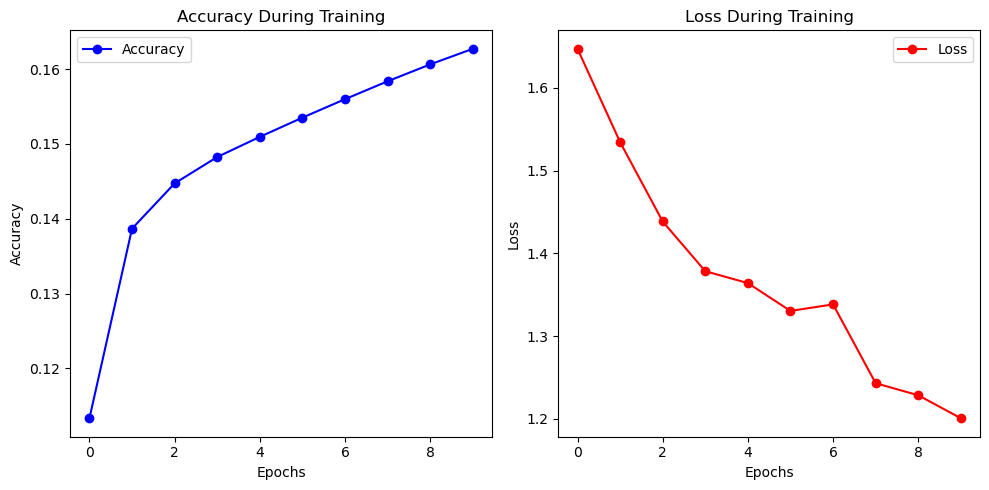

In [27]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), accuracy_list, label='Accuracy', color='b', marker='o')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss_list, label='Loss', color='r', marker='o')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

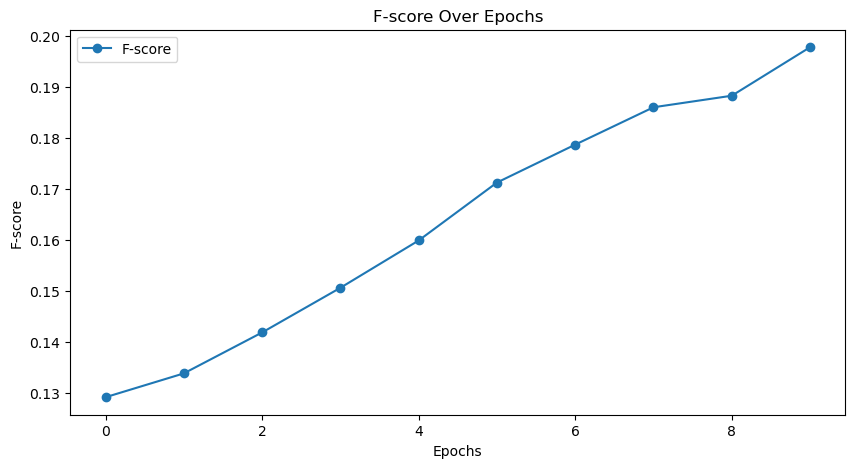

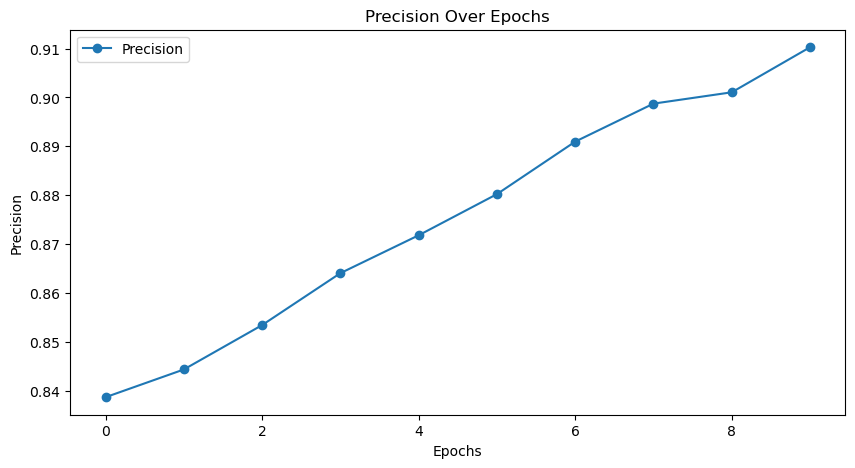

In [28]:
# Plotting F-score
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), f_score_list, label='F-score', marker='o')
plt.title('F-score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F-score')
plt.legend()
plt.show()

# Plotting Precision
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), precision_list, label='Precision', marker='o')
plt.title('Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()